# Dataset

In [1]:
import pandas as pd

data = pd.read_csv('iris.csv', header = None)
data

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [2]:
import numpy as np
X = data.iloc[:, 0:4]
Y = data.iloc[:, 4:]
X = np.array(X)

In [3]:
from sklearn.preprocessing import OneHotEncoder

OHE = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False).fit(Y)

Y = OHE.transform(Y)

In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler

class Custom_Dataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        X_return = torch.tensor(self.X[idx], dtype = torch.float32)
        Y_return = torch.tensor(self.Y[idx], dtype = torch.float32)
        return X_return, Y_return
    
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle = True)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, train_size = 0.8, shuffle = True)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)
X_val_scale = scaler.transform(X_val)

train_dataset = Custom_Dataset(X_train_scale, Y_train)
test_dataset = Custom_Dataset(X_test_scale, Y_test)
val_dataset = Custom_Dataset(X_val_scale, Y_val)

batch_size = 50

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)


# Deep Learning Model

In [5]:
import torch.nn as nn

class ANN_Model(nn.Module):
    def __init__(self, n_features, n_targets):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_features, 50),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            nn.Linear(50, 25),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            nn.Linear(25, 12),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            nn.Linear(12, n_targets),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

# Training

In [6]:
import torch
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
torch.cuda.empty_cache()

def train(model, loss_fn, lr, epochs, train_data, val_data, test_data):
    optimizer = optim.Adam(model.parameters(), lr = lr)
    scaler = torch.cuda.amp.GradScaler()
    lst_loss = []
    lst_accuracy = []
    mean_loss = 0
    mean_accuracy = 0
    lst_mean_loss = []
    lst_mean_accuracy = []
    val_lst_loss = []
    val_lst_accuracy = []
    val_mean_loss = 0
    val_mean_accuracy = 0
    val_lst_mean_loss = []
    val_lst_mean_accuracy = []
    test_lst_loss = []
    test_lst_accuracy = []
    test_mean_loss = 0
    test_mean_accuracy = 0
    test_lst_mean_loss = []
    test_lst_mean_accuracy = []
    for epoch in range(epochs):
        print('Epoch: ', epoch + 1)
        loop = tqdm(train_data)
        for mb, (x_input, y_output) in enumerate(loop, start = 1):
            model.train()
            x_input = x_input.to(device = device)
            y_output = y_output.to(device = device)
            with torch.cuda.amp.autocast():
                prediction = model(x_input)
                loss = loss_fn(prediction, y_output)
            
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            loop.set_postfix(loss_function = loss.item())
            
        model.eval()
        lst_lost = []
        lst_accuracy = []
        for i, data in enumerate(train_data, 0):
            x_input, y_output = data
            x_input = x_input.to(device = device)
            y_output = y_output.to(device = device)
            with torch.no_grad():
                prediction = model(x_input)
                loss = loss_fn(prediction, y_output)
                lst_loss.append(loss.item())
                prediction = torch.argmax(prediction, dim = 1)
                prediction = prediction.cpu().numpy()
                y_output = torch.argmax(y_output, dim = 1)
                y_output = y_output.cpu().numpy()
                accuracy = accuracy_score(y_output, prediction)
                lst_accuracy.append(accuracy)
        
        mean_loss = np.mean(lst_loss)
        lst_mean_loss.append(mean_loss)
        mean_accuracy = np.mean(lst_accuracy)
        lst_mean_accuracy.append(mean_accuracy)
        
        val_lst_lost = []
        val_lst_accuracy = []
        for i, data in enumerate(val_data, 0):
            x_input, y_output = data
            x_input = x_input.to(device = device)
            y_output = y_output.to(device = device)
            with torch.no_grad():
                prediction = model(x_input)
                loss = loss_fn(prediction, y_output)
                val_lst_loss.append(loss.item())
                prediction = torch.argmax(prediction, dim = 1)
                prediction = prediction.cpu().numpy()
                y_output = torch.argmax(y_output, dim = 1)
                y_output = y_output.cpu().numpy()
                accuracy = accuracy_score(y_output, prediction)
                val_lst_accuracy.append(accuracy)
        
        val_mean_loss = np.mean(val_lst_loss)
        val_lst_mean_loss.append(val_mean_loss)
        val_mean_accuracy = np.mean(val_lst_accuracy)
        val_lst_mean_accuracy.append(val_mean_accuracy)
        
        test_lst_lost = []
        test_lst_accuracy = []
        for i, data in enumerate(test_data, 0):
            x_input, y_output = data
            x_input = x_input.to(device = device)
            y_output = y_output.to(device = device)
            with torch.no_grad():
                prediction = model(x_input)
                loss = loss_fn(prediction, y_output)
                test_lst_loss.append(loss.item())
                prediction = torch.argmax(prediction, dim = 1)
                prediction = prediction.cpu().numpy()
                y_output = torch.argmax(y_output, dim = 1)
                y_output = y_output.cpu().numpy()
                accuracy = accuracy_score(y_output, prediction)
                test_lst_accuracy.append(accuracy)
        
        test_mean_loss = np.mean(test_lst_loss)
        test_lst_mean_loss.append(test_mean_loss)
        test_mean_accuracy = np.mean(test_lst_accuracy)
        test_lst_mean_accuracy.append(test_mean_accuracy)

    ax = sns.lineplot(x = range(len(lst_mean_loss)), y = lst_mean_loss, label = "Train")
    ax = sns.lineplot(x = range(len(val_lst_mean_loss)), y = val_lst_mean_loss, label = "Validation")
    ax = sns.lineplot(x = range(len(test_lst_mean_loss)), y = test_lst_mean_loss, label = "Test")
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    
    ax = sns.lineplot(x = range(len(lst_mean_accuracy)), y = lst_mean_accuracy, label = "Train")
    ax = sns.lineplot(x = range(len(val_lst_mean_accuracy)), y = val_lst_mean_accuracy, label = "Validation")
    ax = sns.lineplot(x = range(len(test_lst_mean_accuracy)), y = test_lst_mean_accuracy, label = "Test")
    
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    print("Train Loss: ", lst_mean_loss[-1])
    print("Validation Loss: ", val_lst_mean_loss[-1])
    print("Test Loss", test_lst_mean_loss[-1])
    print("Train Accuracy: ", lst_mean_accuracy[-1])
    print("Validation Accuracy: ", val_lst_mean_accuracy[-1])
    print("Test Accuracy", test_lst_mean_accuracy[-1])
    
    
    return model, lst_mean_loss[-1], val_lst_mean_loss[-1], test_lst_mean_loss[-1], lst_mean_accuracy[-1], val_lst_mean_accuracy[-1], test_lst_mean_accuracy[-1]

Epoch:  1


100%|████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it, loss_function=1.09]


Epoch:  2


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 166.39it/s, loss_function=1.09]


Epoch:  3


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 142.59it/s, loss_function=1.1]


Epoch:  4


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 136.12it/s, loss_function=1.1]


Epoch:  5


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 149.74it/s, loss_function=1.08]


Epoch:  6


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 133.07it/s, loss_function=1.1]


Epoch:  7


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.55it/s, loss_function=1.08]

Epoch:  8



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 271.46it/s, loss_function=1.09]


Epoch:  9


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.04it/s, loss_function=1.1]


Epoch:  10


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.29it/s, loss_function=1.11]


Epoch:  11


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 237.14it/s, loss_function=1.09]


Epoch:  12


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.69it/s, loss_function=1.08]


Epoch:  13


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.96it/s, loss_function=1.09]


Epoch:  14


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.92it/s, loss_function=1.12]


Epoch:  15


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 161.43it/s, loss_function=1.1]


Epoch:  16


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.35it/s, loss_function=1.09]


Epoch:  17


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.75it/s, loss_function=1.11]

Epoch:  18



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 228.19it/s, loss_function=1.09]


Epoch:  19


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 249.43it/s, loss_function=1.12]


Epoch:  20


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.01it/s, loss_function=1.09]


Epoch:  21


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 287.01it/s, loss_function=1.1]


Epoch:  22


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 249.25it/s, loss_function=1.1]


Epoch:  23


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 248.93it/s, loss_function=1.07]


Epoch:  24


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.84it/s, loss_function=1.08]

Epoch:  25



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.61it/s, loss_function=1.11]


Epoch:  26


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 243.33it/s, loss_function=1.09]


Epoch:  27


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.88it/s, loss_function=1.1]


Epoch:  28


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.83it/s, loss_function=1.1]


Epoch:  29


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 249.44it/s, loss_function=1.11]


Epoch:  30


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 253.44it/s, loss_function=1.09]


Epoch:  31


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.96it/s, loss_function=1.1]


Epoch:  32


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.55it/s, loss_function=1.08]


Epoch:  33


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 270.05it/s, loss_function=1.08]


Epoch:  34


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.48it/s, loss_function=1.11]


Epoch:  35


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.10it/s, loss_function=1.1]


Epoch:  36


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 255.07it/s, loss_function=1.09]


Epoch:  37


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.41it/s, loss_function=1.09]


Epoch:  38


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.01it/s, loss_function=1.1]


Epoch:  39


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.28it/s, loss_function=1.09]


Epoch:  40


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.37it/s, loss_function=1.09]


Epoch:  41


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 285.36it/s, loss_function=1.1]


Epoch:  42


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 214.02it/s, loss_function=1.08]

Epoch:  43



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.65it/s, loss_function=1.09]


Epoch:  44


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.18it/s, loss_function=1.07]


Epoch:  45


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.91it/s, loss_function=1.1]


Epoch:  46


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.99it/s, loss_function=1.08]


Epoch:  47


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.60it/s, loss_function=1.08]


Epoch:  48


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.33it/s, loss_function=1.07]


Epoch:  49


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.73it/s, loss_function=1.09]


Epoch:  50


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.29it/s, loss_function=1.09]


Epoch:  51


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.79it/s, loss_function=1.1]


Epoch:  52


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 249.54it/s, loss_function=1.08]


Epoch:  53


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 232.19it/s, loss_function=1.07]


Epoch:  54


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 245.94it/s, loss_function=1.09]


Epoch:  55


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.90it/s, loss_function=1.08]


Epoch:  56


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.24it/s, loss_function=1.1]


Epoch:  57


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.79it/s, loss_function=1.08]


Epoch:  58


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 214.64it/s, loss_function=1.09]


Epoch:  59


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 270.45it/s, loss_function=1.08]


Epoch:  60


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 246.10it/s, loss_function=1.08]

Epoch:  61



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.53it/s, loss_function=1.07]


Epoch:  62


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.33it/s, loss_function=1.06]


Epoch:  63


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 227.93it/s, loss_function=1.08]


Epoch:  64


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.56it/s, loss_function=1.07]


Epoch:  65


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.66it/s, loss_function=1.07]


Epoch:  66


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 215.57it/s, loss_function=1.08]


Epoch:  67


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.53it/s, loss_function=1.08]


Epoch:  68


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 288.62it/s, loss_function=1.08]


Epoch:  69


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 315.48it/s, loss_function=1.07]


Epoch:  70


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.98it/s, loss_function=1.07]


Epoch:  71


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.14it/s, loss_function=1.05]


Epoch:  72


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.58it/s, loss_function=1.06]


Epoch:  73


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.33it/s, loss_function=1.07]


Epoch:  74


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 285.29it/s, loss_function=1.08]


Epoch:  75


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 233.06it/s, loss_function=1.07]


Epoch:  76


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.78it/s, loss_function=1.08]


Epoch:  77


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 232.37it/s, loss_function=1.08]


Epoch:  78


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.43it/s, loss_function=1.11]


Epoch:  79


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.71it/s, loss_function=1.05]


Epoch:  80


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.08it/s, loss_function=1.07]


Epoch:  81


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.97it/s, loss_function=1.08]


Epoch:  82


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.30it/s, loss_function=1.09]

Epoch:  83



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.17it/s, loss_function=1.06]


Epoch:  84


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 185.72it/s, loss_function=1.06]


Epoch:  85


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.40it/s, loss_function=1.09]


Epoch:  86


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.97it/s, loss_function=1.06]


Epoch:  87


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 271.21it/s, loss_function=1.05]


Epoch:  88


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 223.74it/s, loss_function=1.09]


Epoch:  89


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.18it/s, loss_function=1.08]


Epoch:  90


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.89it/s, loss_function=1.06]


Epoch:  91


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.56it/s, loss_function=1.07]

Epoch:  92



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.88it/s, loss_function=1.08]


Epoch:  93


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 219.13it/s, loss_function=1.05]


Epoch:  94


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 271.46it/s, loss_function=1.04]


Epoch:  95


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 225.71it/s, loss_function=1.06]


Epoch:  96


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 264.65it/s, loss_function=1.06]


Epoch:  97


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.87it/s, loss_function=1.07]


Epoch:  98


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.56it/s, loss_function=1.07]


Epoch:  99


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.79it/s, loss_function=1.07]


Epoch:  100


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 227.82it/s, loss_function=1.08]


Epoch:  101


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 174.38it/s, loss_function=1.05]


Epoch:  102


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 153.55it/s, loss_function=1.06]


Epoch:  103


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.26it/s, loss_function=1.07]


Epoch:  104


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.25it/s, loss_function=1.05]


Epoch:  105


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 214.42it/s, loss_function=1.06]


Epoch:  106


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.09it/s, loss_function=1.06]


Epoch:  107


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 157.67it/s, loss_function=1.04]


Epoch:  108


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 249.31it/s, loss_function=1.04]


Epoch:  109


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.40it/s, loss_function=1.05]


Epoch:  110


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.55it/s, loss_function=1.02]


Epoch:  111


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.93it/s, loss_function=1.04]


Epoch:  112


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.50it/s, loss_function=1.06]


Epoch:  113


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 201.93it/s, loss_function=1.02]


Epoch:  114


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.67it/s, loss_function=1.05]


Epoch:  115


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.21it/s, loss_function=1.04]


Epoch:  116


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.76it/s, loss_function=1.03]


Epoch:  117


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.93it/s, loss_function=1.05]


Epoch:  118


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.52it/s, loss_function=1.04]


Epoch:  119


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.69it/s, loss_function=1.03]


Epoch:  120


100%|██████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.83it/s, loss_function=1]


Epoch:  121


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 210.50it/s, loss_function=1.02]


Epoch:  122


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 244.12it/s, loss_function=1.02]


Epoch:  123


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.66it/s, loss_function=1.03]


Epoch:  124


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.24it/s, loss_function=1.01]


Epoch:  125


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.82it/s, loss_function=1.05]

Epoch:  126



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.16it/s, loss_function=0.999]


Epoch:  127


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 201.21it/s, loss_function=1.02]


Epoch:  128


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.39it/s, loss_function=1.03]


Epoch:  129


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.40it/s, loss_function=1.03]


Epoch:  130


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 170.39it/s, loss_function=1.01]


Epoch:  131


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 247.00it/s, loss_function=1.02]


Epoch:  132


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 243.03it/s, loss_function=1.01]


Epoch:  133


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.99it/s, loss_function=1.04]


Epoch:  134


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 240.00it/s, loss_function=1.03]


Epoch:  135


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.63it/s, loss_function=1.02]


Epoch:  136


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.09it/s, loss_function=1.01]


Epoch:  137


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 219.03it/s, loss_function=1.04]


Epoch:  138


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.62it/s, loss_function=1.02]


Epoch:  139


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.58it/s, loss_function=1.02]


Epoch:  140


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 185.28it/s, loss_function=1.05]


Epoch:  141


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.98it/s, loss_function=1.01]


Epoch:  142


100%|██████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.81it/s, loss_function=1]


Epoch:  143


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.18it/s, loss_function=0.975]


Epoch:  144


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 211.25it/s, loss_function=1.03]

Epoch:  145



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.72it/s, loss_function=0.999]


Epoch:  146


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.14it/s, loss_function=0.986]


Epoch:  147


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.97it/s, loss_function=1.04]


Epoch:  148


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 196.66it/s, loss_function=0.975]


Epoch:  149


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 226.15it/s, loss_function=0.991]


Epoch:  150


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.01it/s, loss_function=0.992]


Epoch:  151


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.68it/s, loss_function=1.02]


Epoch:  152


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 248.84it/s, loss_function=0.987]


Epoch:  153


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.86it/s, loss_function=0.975]


Epoch:  154


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.44it/s, loss_function=0.979]


Epoch:  155


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.93it/s, loss_function=0.997]


Epoch:  156


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.18it/s, loss_function=0.973]

Epoch:  157



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.67it/s, loss_function=0.947]


Epoch:  158


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.06it/s, loss_function=0.992]

Epoch:  159



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.79it/s, loss_function=0.961]


Epoch:  160


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.83it/s, loss_function=0.978]


Epoch:  161


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 284.26it/s, loss_function=1.01]


Epoch:  162


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.01it/s, loss_function=0.96]

Epoch:  163



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.50it/s, loss_function=0.956]


Epoch:  164


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.90it/s, loss_function=0.999]


Epoch:  165


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.50it/s, loss_function=1.01]


Epoch:  166


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.68it/s, loss_function=0.927]


Epoch:  167


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.96it/s, loss_function=0.978]


Epoch:  168


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 285.39it/s, loss_function=0.972]


Epoch:  169


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.21it/s, loss_function=0.948]


Epoch:  170


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.56it/s, loss_function=0.959]

Epoch:  171



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.49it/s, loss_function=0.911]


Epoch:  172


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.32it/s, loss_function=0.954]


Epoch:  173


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 249.48it/s, loss_function=0.964]


Epoch:  174


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.75it/s, loss_function=0.931]


Epoch:  175


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.37it/s, loss_function=0.947]


Epoch:  176


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.81it/s, loss_function=0.935]


Epoch:  177


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.76it/s, loss_function=0.941]


Epoch:  178


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.21it/s, loss_function=0.991]


Epoch:  179


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.11it/s, loss_function=0.922]


Epoch:  180


100%|██████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.02it/s, loss_function=1]


Epoch:  181


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.31it/s, loss_function=0.991]


Epoch:  182


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.26it/s, loss_function=0.922]


Epoch:  183


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.58it/s, loss_function=0.894]


Epoch:  184


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.13it/s, loss_function=0.887]

Epoch:  185



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 240.25it/s, loss_function=0.954]


Epoch:  186


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.83it/s, loss_function=0.991]


Epoch:  187


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.61it/s, loss_function=0.922]


Epoch:  188


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 285.22it/s, loss_function=0.947]


Epoch:  189


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.43it/s, loss_function=0.93]


Epoch:  190


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.62it/s, loss_function=0.922]


Epoch:  191


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.17it/s, loss_function=0.962]


Epoch:  192


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.08it/s, loss_function=0.938]


Epoch:  193


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.46it/s, loss_function=0.926]


Epoch:  194


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.06it/s, loss_function=0.934]


Epoch:  195


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 269.02it/s, loss_function=0.913]


Epoch:  196


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.17it/s, loss_function=0.942]


Epoch:  197


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.50it/s, loss_function=0.909]


Epoch:  198


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.92it/s, loss_function=0.87]


Epoch:  199


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.12it/s, loss_function=0.875]


Epoch:  200


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.60it/s, loss_function=0.943]


Epoch:  201


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.36it/s, loss_function=0.923]


Epoch:  202


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.22it/s, loss_function=0.892]


Epoch:  203


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.97it/s, loss_function=0.882]


Epoch:  204


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.74it/s, loss_function=0.871]


Epoch:  205


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.45it/s, loss_function=0.904]


Epoch:  206


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.96it/s, loss_function=0.872]

Epoch:  207



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.03it/s, loss_function=0.86]


Epoch:  208


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.34it/s, loss_function=0.89]


Epoch:  209


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.62it/s, loss_function=0.924]


Epoch:  210


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.39it/s, loss_function=0.943]

Epoch:  211



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.68it/s, loss_function=0.901]


Epoch:  212


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.87it/s, loss_function=0.908]


Epoch:  213


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.20it/s, loss_function=0.904]


Epoch:  214


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.56it/s, loss_function=0.89]


Epoch:  215


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.40it/s, loss_function=0.922]


Epoch:  216


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 285.38it/s, loss_function=0.918]


Epoch:  217


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.22it/s, loss_function=0.855]


Epoch:  218


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.93it/s, loss_function=0.876]


Epoch:  219


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 149.53it/s, loss_function=0.921]


Epoch:  220


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.27it/s, loss_function=0.87]


Epoch:  221


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 171.20it/s, loss_function=0.874]


Epoch:  222


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.43it/s, loss_function=0.927]

Epoch:  223



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.17it/s, loss_function=0.951]


Epoch:  224


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 166.40it/s, loss_function=0.846]


Epoch:  225


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 270.34it/s, loss_function=0.874]


Epoch:  226


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.61it/s, loss_function=0.934]

Epoch:  227



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.56it/s, loss_function=0.913]


Epoch:  228


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.13it/s, loss_function=0.91]


Epoch:  229


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.61it/s, loss_function=0.795]

Epoch:  230



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.59it/s, loss_function=0.841]


Epoch:  231


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.02it/s, loss_function=0.854]


Epoch:  232


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.02it/s, loss_function=0.811]


Epoch:  233


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.86it/s, loss_function=0.823]


Epoch:  234


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.78it/s, loss_function=0.859]


Epoch:  235


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.63it/s, loss_function=0.821]


Epoch:  236


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.99it/s, loss_function=0.889]


Epoch:  237


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.96it/s, loss_function=0.86]


Epoch:  238


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.94it/s, loss_function=0.849]


Epoch:  239


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.10it/s, loss_function=0.823]


Epoch:  240


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.53it/s, loss_function=0.833]


Epoch:  241


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.22it/s, loss_function=0.843]


Epoch:  242


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 157.67it/s, loss_function=0.816]


Epoch:  243


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.55it/s, loss_function=0.83]


Epoch:  244


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 249.40it/s, loss_function=0.859]


Epoch:  245


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.35it/s, loss_function=0.889]


Epoch:  246


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.30it/s, loss_function=0.888]


Epoch:  247


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 285.19it/s, loss_function=0.835]


Epoch:  248


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.32it/s, loss_function=0.825]


Epoch:  249


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.27it/s, loss_function=0.881]


Epoch:  250


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.82it/s, loss_function=0.858]


Epoch:  251


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.98it/s, loss_function=0.886]


Epoch:  252


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 285.31it/s, loss_function=0.901]


Epoch:  253


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.51it/s, loss_function=0.853]


Epoch:  254


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 272.06it/s, loss_function=0.789]


Epoch:  255


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.54it/s, loss_function=0.916]


Epoch:  256


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 261.17it/s, loss_function=0.831]


Epoch:  257


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.61it/s, loss_function=0.849]


Epoch:  258


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.41it/s, loss_function=0.871]


Epoch:  259


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.81it/s, loss_function=0.882]

Epoch:  260



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.19it/s, loss_function=0.852]


Epoch:  261


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.73it/s, loss_function=0.838]


Epoch:  262


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.49it/s, loss_function=0.841]


Epoch:  263


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.96it/s, loss_function=0.837]


Epoch:  264


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 272.17it/s, loss_function=0.853]


Epoch:  265


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.65it/s, loss_function=0.847]


Epoch:  266


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.84it/s, loss_function=0.806]


Epoch:  267


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.47it/s, loss_function=0.869]


Epoch:  268


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.65it/s, loss_function=0.765]


Epoch:  269


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.67it/s, loss_function=0.807]


Epoch:  270


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.81it/s, loss_function=0.868]

Epoch:  271



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.56it/s, loss_function=0.829]


Epoch:  272


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 142.61it/s, loss_function=0.816]


Epoch:  273


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 285.19it/s, loss_function=0.849]


Epoch:  274


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.58it/s, loss_function=0.783]


Epoch:  275


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.68it/s, loss_function=0.811]


Epoch:  276


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.53it/s, loss_function=0.843]


Epoch:  277


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.30it/s, loss_function=0.833]


Epoch:  278


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.67it/s, loss_function=0.836]


Epoch:  279


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.60it/s, loss_function=0.838]


Epoch:  280


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 285.34it/s, loss_function=0.836]


Epoch:  281


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.63it/s, loss_function=0.866]


Epoch:  282


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 285.20it/s, loss_function=0.847]


Epoch:  283


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.38it/s, loss_function=0.829]


Epoch:  284


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.84it/s, loss_function=0.861]


Epoch:  285


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.19it/s, loss_function=0.834]


Epoch:  286


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.14it/s, loss_function=0.791]


Epoch:  287


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.91it/s, loss_function=0.799]


Epoch:  288


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 285.31it/s, loss_function=0.783]


Epoch:  289


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.37it/s, loss_function=0.839]


Epoch:  290


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 315.25it/s, loss_function=0.785]


Epoch:  291


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.08it/s, loss_function=0.794]


Epoch:  292


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.69it/s, loss_function=0.817]


Epoch:  293


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.49it/s, loss_function=0.84]


Epoch:  294


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.64it/s, loss_function=0.773]


Epoch:  295


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.77it/s, loss_function=0.831]


Epoch:  296


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.04it/s, loss_function=0.815]


Epoch:  297


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.60it/s, loss_function=0.757]


Epoch:  298


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 315.13it/s, loss_function=0.768]


Epoch:  299


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.66it/s, loss_function=0.826]


Epoch:  300


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.54it/s, loss_function=0.791]


Epoch:  301


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.72it/s, loss_function=0.8]


Epoch:  302


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.99it/s, loss_function=0.738]


Epoch:  303


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.91it/s, loss_function=0.814]


Epoch:  304


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.62it/s, loss_function=0.85]


Epoch:  305


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 283.70it/s, loss_function=0.862]


Epoch:  306


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 157.15it/s, loss_function=0.803]


Epoch:  307


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.29it/s, loss_function=0.78]


Epoch:  308


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.01it/s, loss_function=0.777]

Epoch:  309



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.08it/s, loss_function=0.822]

Epoch:  310



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.58it/s, loss_function=0.768]


Epoch:  311


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.29it/s, loss_function=0.715]

Epoch:  312



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 165.65it/s, loss_function=0.788]


Epoch:  313


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 196.93it/s, loss_function=0.77]


Epoch:  314


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 201.05it/s, loss_function=0.742]


Epoch:  315


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.06it/s, loss_function=0.784]


Epoch:  316


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 145.31it/s, loss_function=0.856]


Epoch:  317


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.55it/s, loss_function=0.758]


Epoch:  318


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.04it/s, loss_function=0.756]


Epoch:  319


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.03it/s, loss_function=0.774]


Epoch:  320


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 124.55it/s, loss_function=0.805]

Epoch:  321



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.74it/s, loss_function=0.782]

Epoch:  322



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 217.94it/s, loss_function=0.832]


Epoch:  323


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.32it/s, loss_function=0.82]


Epoch:  324


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 196.80it/s, loss_function=0.782]


Epoch:  325


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 110.11it/s, loss_function=0.769]


Epoch:  326


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 162.00it/s, loss_function=0.744]

Epoch:  327



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 136.62it/s, loss_function=0.786]


Epoch:  328


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 156.68it/s, loss_function=0.811]


Epoch:  329


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 148.24it/s, loss_function=0.788]


Epoch:  330


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 237.29it/s, loss_function=0.725]


Epoch:  331


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.41it/s, loss_function=0.825]


Epoch:  332


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.24it/s, loss_function=0.822]


Epoch:  333


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.14it/s, loss_function=0.75]


Epoch:  334


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.56it/s, loss_function=0.832]


Epoch:  335


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.09it/s, loss_function=0.749]


Epoch:  336


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 224.02it/s, loss_function=0.755]


Epoch:  337


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 228.66it/s, loss_function=0.853]


Epoch:  338


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 240.20it/s, loss_function=0.871]


Epoch:  339


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.04it/s, loss_function=0.739]


Epoch:  340


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.85it/s, loss_function=0.778]


Epoch:  341


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.17it/s, loss_function=0.785]


Epoch:  342


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 248.74it/s, loss_function=0.754]


Epoch:  343


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.46it/s, loss_function=0.799]


Epoch:  344


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.69it/s, loss_function=0.804]


Epoch:  345


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.22it/s, loss_function=0.79]


Epoch:  346


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.96it/s, loss_function=0.807]


Epoch:  347


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.82it/s, loss_function=0.741]

Epoch:  348



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 219.33it/s, loss_function=0.779]


Epoch:  349


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 210.87it/s, loss_function=0.8]


Epoch:  350


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.27it/s, loss_function=0.832]


Epoch:  351


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 215.83it/s, loss_function=0.772]


Epoch:  352


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 284.63it/s, loss_function=0.772]


Epoch:  353


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 270.51it/s, loss_function=0.854]


Epoch:  354


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.51it/s, loss_function=0.752]


Epoch:  355


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 283.43it/s, loss_function=0.761]


Epoch:  356


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 200.32it/s, loss_function=0.783]


Epoch:  357


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 249.33it/s, loss_function=0.801]


Epoch:  358


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 208.17it/s, loss_function=0.753]


Epoch:  359


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 266.71it/s, loss_function=0.789]


Epoch:  360


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.97it/s, loss_function=0.813]


Epoch:  361


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 228.78it/s, loss_function=0.812]


Epoch:  362


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.14it/s, loss_function=0.798]


Epoch:  363


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 248.25it/s, loss_function=0.77]


Epoch:  364


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 247.87it/s, loss_function=0.728]


Epoch:  365


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 250.37it/s, loss_function=0.735]

Epoch:  366



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 211.47it/s, loss_function=0.72]


Epoch:  367


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.84it/s, loss_function=0.761]


Epoch:  368


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 140.24it/s, loss_function=0.753]


Epoch:  369


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 173.92it/s, loss_function=0.796]


Epoch:  370


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 219.45it/s, loss_function=0.753]


Epoch:  371


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.04it/s, loss_function=0.797]


Epoch:  372


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.02it/s, loss_function=0.783]


Epoch:  373


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.40it/s, loss_function=0.718]


Epoch:  374


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.46it/s, loss_function=0.838]


Epoch:  375


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.98it/s, loss_function=0.81]


Epoch:  376


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.28it/s, loss_function=0.753]


Epoch:  377


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 265.48it/s, loss_function=0.785]


Epoch:  378


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 244.03it/s, loss_function=0.753]


Epoch:  379


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.33it/s, loss_function=0.835]

Epoch:  380



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.54it/s, loss_function=0.794]


Epoch:  381


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 248.48it/s, loss_function=0.77]


Epoch:  382


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 283.90it/s, loss_function=0.741]


Epoch:  383


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.92it/s, loss_function=0.717]


Epoch:  384


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.20it/s, loss_function=0.798]


Epoch:  385


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.58it/s, loss_function=0.871]

Epoch: 

 386


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.70it/s, loss_function=0.752]


Epoch:  387


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 270.58it/s, loss_function=0.764]

Epoch:  388



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.56it/s, loss_function=0.81]


Epoch:  389


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 269.63it/s, loss_function=0.819]


Epoch:  390


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.42it/s, loss_function=0.74]


Epoch:  391


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.47it/s, loss_function=0.731]


Epoch:  392


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.71it/s, loss_function=0.727]


Epoch:  393


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 285.53it/s, loss_function=0.756]


Epoch:  394


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 283.60it/s, loss_function=0.745]


Epoch:  395


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 247.96it/s, loss_function=0.786]

Epoch:  396



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 219.95it/s, loss_function=0.729]


Epoch:  397


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 257.22it/s, loss_function=0.699]

Epoch:  398



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.34it/s, loss_function=0.826]


Epoch:  399


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 249.21it/s, loss_function=0.766]


Epoch:  400


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 249.54it/s, loss_function=0.791]


Epoch:  401


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.00it/s, loss_function=0.755]


Epoch:  402


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 240.14it/s, loss_function=0.704]


Epoch:  403


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.24it/s, loss_function=0.717]


Epoch:  404


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.17it/s, loss_function=0.804]


Epoch:  405


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 236.83it/s, loss_function=0.734]


Epoch:  406


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.62it/s, loss_function=0.787]


Epoch:  407


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.57it/s, loss_function=0.742]


Epoch:  408


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.10it/s, loss_function=0.699]


Epoch:  409


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.62it/s, loss_function=0.73]


Epoch:  410


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 272.00it/s, loss_function=0.745]

Epoch:  411



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.87it/s, loss_function=0.765]


Epoch:  412


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 228.65it/s, loss_function=0.84]

Epoch:  413



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 169.72it/s, loss_function=0.745]


Epoch:  414


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.36it/s, loss_function=0.717]

Epoch:  415



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.49it/s, loss_function=0.684]


Epoch:  416


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 256.88it/s, loss_function=0.71]


Epoch:  417


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.14it/s, loss_function=0.734]


Epoch:  418


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.45it/s, loss_function=0.714]


Epoch:  419


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 248.57it/s, loss_function=0.773]


Epoch:  420


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.36it/s, loss_function=0.735]


Epoch:  421


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.43it/s, loss_function=0.733]


Epoch:  422


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 248.93it/s, loss_function=0.758]


Epoch:  423


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 271.05it/s, loss_function=0.684]


Epoch:  424


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 261.28it/s, loss_function=0.757]


Epoch:  425


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 263.53it/s, loss_function=0.797]


Epoch:  426


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 201.58it/s, loss_function=0.748]


Epoch:  427


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.27it/s, loss_function=0.741]


Epoch:  428


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.04it/s, loss_function=0.747]


Epoch:  429


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 240.73it/s, loss_function=0.825]


Epoch:  430


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.30it/s, loss_function=0.702]


Epoch:  431


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.17it/s, loss_function=0.747]

Epoch:  432



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 271.10it/s, loss_function=0.666]


Epoch:  433


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.99it/s, loss_function=0.721]

Epoch:  434



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.26it/s, loss_function=0.666]


Epoch:  435


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.57it/s, loss_function=0.781]


Epoch:  436


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.01it/s, loss_function=0.729]


Epoch:  437


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.83it/s, loss_function=0.712]

Epoch:  438



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.77it/s, loss_function=0.799]


Epoch:  439


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 283.34it/s, loss_function=0.74]


Epoch:  440


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.07it/s, loss_function=0.748]


Epoch:  441


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.62it/s, loss_function=0.704]

Epoch:  442



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.62it/s, loss_function=0.703]


Epoch:  443


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 248.20it/s, loss_function=0.703]


Epoch:  444


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.82it/s, loss_function=0.739]


Epoch:  445


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.71it/s, loss_function=0.754]


Epoch:  446


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 183.97it/s, loss_function=0.729]


Epoch:  447


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 250.46it/s, loss_function=0.734]


Epoch:  448


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.57it/s, loss_function=0.729]


Epoch:  449


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 269.61it/s, loss_function=0.7]


Epoch:  450


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.75it/s, loss_function=0.698]


Epoch:  451


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 271.14it/s, loss_function=0.737]


Epoch:  452


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.06it/s, loss_function=0.688]


Epoch:  453


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.63it/s, loss_function=0.7]

Epoch:  454



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.66it/s, loss_function=0.737]


Epoch:  455


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.41it/s, loss_function=0.705]

Epoch:  456



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 170.88it/s, loss_function=0.732]


Epoch:  457


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 185.82it/s, loss_function=0.763]


Epoch:  458


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.21it/s, loss_function=0.717]


Epoch:  459


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 174.51it/s, loss_function=0.724]


Epoch:  460


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 285.58it/s, loss_function=0.73]


Epoch:  461


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.74it/s, loss_function=0.632]


Epoch:  462


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 166.11it/s, loss_function=0.667]


Epoch:  463


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 266.11it/s, loss_function=0.638]


Epoch:  464


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.01it/s, loss_function=0.708]

Epoch:  465



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 169.33it/s, loss_function=0.701]


Epoch:  466


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.14it/s, loss_function=0.73]


Epoch:  467


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 224.21it/s, loss_function=0.68]


Epoch:  468


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.32it/s, loss_function=0.727]


Epoch:  469


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.45it/s, loss_function=0.769]


Epoch:  470


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 248.20it/s, loss_function=0.724]


Epoch:  471


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.40it/s, loss_function=0.757]


Epoch:  472


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.48it/s, loss_function=0.653]


Epoch:  473


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.51it/s, loss_function=0.723]


Epoch:  474


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.00it/s, loss_function=0.692]


Epoch:  475


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.38it/s, loss_function=0.739]


Epoch:  476


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 285.99it/s, loss_function=0.656]


Epoch:  477


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.19it/s, loss_function=0.686]


Epoch:  478


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.92it/s, loss_function=0.729]


Epoch:  479


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 216.88it/s, loss_function=0.675]


Epoch:  480


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.50it/s, loss_function=0.723]


Epoch:  481


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.43it/s, loss_function=0.661]


Epoch:  482


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.62it/s, loss_function=0.722]

Epoch:  483



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.40it/s, loss_function=0.715]

Epoch:  484



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.82it/s, loss_function=0.751]


Epoch:  485


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 233.89it/s, loss_function=0.689]


Epoch:  486


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.16it/s, loss_function=0.668]


Epoch:  487


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.21it/s, loss_function=0.693]


Epoch:  488


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.24it/s, loss_function=0.693]


Epoch:  489


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.66it/s, loss_function=0.688]


Epoch:  490


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 283.83it/s, loss_function=0.729]


Epoch:  491


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 284.75it/s, loss_function=0.66]


Epoch:  492


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.58it/s, loss_function=0.691]


Epoch:  493


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.79it/s, loss_function=0.707]


Epoch:  494


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.47it/s, loss_function=0.723]


Epoch:  495


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 188.94it/s, loss_function=0.719]


Epoch:  496


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.46it/s, loss_function=0.678]


Epoch:  497


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.86it/s, loss_function=0.749]


Epoch:  498


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 228.63it/s, loss_function=0.707]


Epoch:  499


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.55it/s, loss_function=0.736]


Epoch:  500


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 243.79it/s, loss_function=0.64]


Epoch:  501


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 288.41it/s, loss_function=0.708]

Epoch:  502



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.16it/s, loss_function=0.674]


Epoch:  503


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.46it/s, loss_function=0.715]


Epoch:  504


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.76it/s, loss_function=0.761]


Epoch:  505


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.37it/s, loss_function=0.76]


Epoch:  506


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 284.45it/s, loss_function=0.677]


Epoch:  507


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 299.25it/s, loss_function=0.684]


Epoch:  508


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.01it/s, loss_function=0.713]


Epoch:  509


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.11it/s, loss_function=0.703]


Epoch:  510


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.84it/s, loss_function=0.658]


Epoch:  511


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.23it/s, loss_function=0.72]


Epoch:  512


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.83it/s, loss_function=0.703]


Epoch:  513


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 240.18it/s, loss_function=0.705]

Epoch:  514



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 168.65it/s, loss_function=0.747]


Epoch:  515


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.30it/s, loss_function=0.678]


Epoch:  516


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 250.07it/s, loss_function=0.748]


Epoch:  517


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 127.10it/s, loss_function=0.688]


Epoch:  518


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.94it/s, loss_function=0.716]


Epoch:  519


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.95it/s, loss_function=0.699]


Epoch:  520


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 261.01it/s, loss_function=0.727]

Epoch:  521



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.12it/s, loss_function=0.681]


Epoch:  522


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.33it/s, loss_function=0.674]


Epoch:  523


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.19it/s, loss_function=0.689]


Epoch:  524


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 211.50it/s, loss_function=0.703]


Epoch:  525


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.37it/s, loss_function=0.818]


Epoch:  526


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.41it/s, loss_function=0.657]


Epoch:  527


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.32it/s, loss_function=0.76]


Epoch:  528


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.83it/s, loss_function=0.701]


Epoch:  529


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 267.43it/s, loss_function=0.69]


Epoch:  530


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.47it/s, loss_function=0.717]


Epoch:  531


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 270.37it/s, loss_function=0.722]


Epoch:  532


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.57it/s, loss_function=0.663]


Epoch:  533


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 258.75it/s, loss_function=0.664]


Epoch:  534


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.44it/s, loss_function=0.703]


Epoch:  535


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.13it/s, loss_function=0.689]


Epoch:  536


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 200.01it/s, loss_function=0.685]


Epoch:  537


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.42it/s, loss_function=0.725]


Epoch:  538


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 313.63it/s, loss_function=0.725]


Epoch:  539


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.68it/s, loss_function=0.679]


Epoch:  540


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.59it/s, loss_function=0.726]


Epoch:  541


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 271.66it/s, loss_function=0.685]


Epoch:  542


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.26it/s, loss_function=0.62]


Epoch:  543


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.42it/s, loss_function=0.693]


Epoch:  544


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.38it/s, loss_function=0.727]


Epoch:  545


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 267.48it/s, loss_function=0.639]


Epoch:  546


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.95it/s, loss_function=0.671]


Epoch:  547


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.15it/s, loss_function=0.713]


Epoch:  548


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.36it/s, loss_function=0.699]


Epoch:  549


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 272.34it/s, loss_function=0.67]


Epoch:  550


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.25it/s, loss_function=0.653]


Epoch:  551


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.85it/s, loss_function=0.72]


Epoch:  552


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.99it/s, loss_function=0.714]


Epoch:  553


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.50it/s, loss_function=0.735]


Epoch:  554


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 284.73it/s, loss_function=0.699]


Epoch:  555


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.29it/s, loss_function=0.698]


Epoch:  556


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.84it/s, loss_function=0.729]


Epoch:  557


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 226.14it/s, loss_function=0.709]


Epoch:  558


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 153.00it/s, loss_function=0.719]


Epoch:  559


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 172.58it/s, loss_function=0.652]


Epoch:  560


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 244.04it/s, loss_function=0.679]


Epoch:  561


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 200.51it/s, loss_function=0.674]


Epoch:  562


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.70it/s, loss_function=0.689]

Epoch:  563



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.41it/s, loss_function=0.704]


Epoch:  564


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.31it/s, loss_function=0.637]


Epoch:  565


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 265.70it/s, loss_function=0.712]

Epoch:  566



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 142.31it/s, loss_function=0.711]

Epoch:  567



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.01it/s, loss_function=0.746]


Epoch:  568


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.81it/s, loss_function=0.737]


Epoch:  569


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 119.87it/s, loss_function=0.669]

Epoch:  570



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 284.22it/s, loss_function=0.714]


Epoch:  571


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 161.74it/s, loss_function=0.681]


Epoch:  572


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.89it/s, loss_function=0.676]


Epoch:  573


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 231.11it/s, loss_function=0.676]


Epoch:  574


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.77it/s, loss_function=0.693]


Epoch:  575


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 184.58it/s, loss_function=0.662]


Epoch:  576


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.16it/s, loss_function=0.711]


Epoch:  577


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 167.67it/s, loss_function=0.684]


Epoch:  578


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.93it/s, loss_function=0.71]


Epoch:  579


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 253.92it/s, loss_function=0.649]

Epoch:  580



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.67it/s, loss_function=0.69]

Epoch:  581



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.77it/s, loss_function=0.691]


Epoch:  582


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 225.88it/s, loss_function=0.682]


Epoch:  583


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 285.02it/s, loss_function=0.675]


Epoch:  584


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 149.03it/s, loss_function=0.619]

Epoch:  585



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 179.46it/s, loss_function=0.698]


Epoch:  586


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 314.34it/s, loss_function=0.674]


Epoch:  587


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 183.57it/s, loss_function=0.634]

Epoch:  588



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 224.69it/s, loss_function=0.74]


Epoch:  589


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.58it/s, loss_function=0.715]


Epoch:  590


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.31it/s, loss_function=0.748]


Epoch:  591


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 284.75it/s, loss_function=0.635]

Epoch:  592



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.22it/s, loss_function=0.628]


Epoch:  593


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.19it/s, loss_function=0.683]


Epoch:  594


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.14it/s, loss_function=0.744]

Epoch:  595



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.30it/s, loss_function=0.683]


Epoch:  596


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.48it/s, loss_function=0.699]


Epoch:  597


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 270.57it/s, loss_function=0.666]


Epoch:  598


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.06it/s, loss_function=0.693]

Epoch:  599



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.25it/s, loss_function=0.675]


Epoch:  600


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.71it/s, loss_function=0.689]


Epoch:  601


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.62it/s, loss_function=0.616]

Epoch:  602



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 166.79it/s, loss_function=0.723]

Epoch:  603



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.38it/s, loss_function=0.666]


Epoch:  604


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 208.62it/s, loss_function=0.666]


Epoch:  605


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.11it/s, loss_function=0.656]


Epoch:  606


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.25it/s, loss_function=0.669]


Epoch:  607


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.97it/s, loss_function=0.701]


Epoch:  608


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.55it/s, loss_function=0.695]


Epoch:  609


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.17it/s, loss_function=0.697]

Epoch:  610



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 225.80it/s, loss_function=0.745]


Epoch:  611


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.68it/s, loss_function=0.639]


Epoch:  612


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 169.95it/s, loss_function=0.642]


Epoch:  613


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 258.85it/s, loss_function=0.661]


Epoch:  614


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.04it/s, loss_function=0.683]


Epoch:  615


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.55it/s, loss_function=0.675]


Epoch:  616


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.16it/s, loss_function=0.709]


Epoch:  617


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 224.90it/s, loss_function=0.683]


Epoch:  618


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.63it/s, loss_function=0.647]


Epoch:  619


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.99it/s, loss_function=0.727]


Epoch:  620


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.76it/s, loss_function=0.673]


Epoch:  621


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 255.71it/s, loss_function=0.75]


Epoch:  622


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 231.60it/s, loss_function=0.697]


Epoch:  623


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 261.68it/s, loss_function=0.642]


Epoch:  624


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 135.26it/s, loss_function=0.683]


Epoch:  625


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.45it/s, loss_function=0.6]


Epoch:  626


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.01it/s, loss_function=0.635]

Epoch:  627



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.33it/s, loss_function=0.645]


Epoch:  628


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.37it/s, loss_function=0.675]


Epoch:  629


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.83it/s, loss_function=0.704]


Epoch:  630


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.99it/s, loss_function=0.673]


Epoch:  631


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.66it/s, loss_function=0.755]


Epoch:  632


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 283.74it/s, loss_function=0.685]


Epoch:  633


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 285.19it/s, loss_function=0.633]


Epoch:  634


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 219.57it/s, loss_function=0.612]

Epoch:  635



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.43it/s, loss_function=0.63]


Epoch:  636


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 224.98it/s, loss_function=0.657]


Epoch:  637


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 271.75it/s, loss_function=0.649]


Epoch:  638


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 226.72it/s, loss_function=0.624]


Epoch:  639


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.58it/s, loss_function=0.623]

Epoch: 

 640


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.93it/s, loss_function=0.679]

Epoch:  641



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 185.88it/s, loss_function=0.623]

Epoch:  642



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 215.82it/s, loss_function=0.642]


Epoch:  643


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 183.98it/s, loss_function=0.64]

Epoch:  644



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.65it/s, loss_function=0.633]


Epoch:  645


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.65it/s, loss_function=0.639]


Epoch:  646


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.26it/s, loss_function=0.613]


Epoch:  647


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 196.73it/s, loss_function=0.688]

Epoch:  648



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.16it/s, loss_function=0.712]


Epoch:  649


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.50it/s, loss_function=0.695]

Epoch:  650



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 178.21it/s, loss_function=0.712]

Epoch:  651



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 215.55it/s, loss_function=0.662]


Epoch:  652


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.06it/s, loss_function=0.629]


Epoch:  653


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 184.77it/s, loss_function=0.639]

Epoch:  654



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 280.32it/s, loss_function=0.703]


Epoch:  655


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.19it/s, loss_function=0.688]


Epoch:  656


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.71it/s, loss_function=0.644]


Epoch:  657


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 217.31it/s, loss_function=0.67]

Epoch:  658



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.30it/s, loss_function=0.65]


Epoch:  659


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 241.67it/s, loss_function=0.637]


Epoch:  660


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.23it/s, loss_function=0.657]

Epoch:  661



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.81it/s, loss_function=0.675]

Epoch:  662



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.78it/s, loss_function=0.64]


Epoch:  663


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.98it/s, loss_function=0.658]

Epoch:  664



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 228.97it/s, loss_function=0.665]

Epoch:  665



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.77it/s, loss_function=0.623]


Epoch:  666


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 228.98it/s, loss_function=0.656]


Epoch:  667


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.89it/s, loss_function=0.623]

Epoch:  668



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.94it/s, loss_function=0.64]


Epoch:  669


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.99it/s, loss_function=0.65]


Epoch:  670


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.61it/s, loss_function=0.672]

Epoch:  671



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.95it/s, loss_function=0.635]


Epoch:  672


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.25it/s, loss_function=0.635]


Epoch:  673


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 185.03it/s, loss_function=0.674]


Epoch:  674


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.55it/s, loss_function=0.619]


Epoch:  675


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.45it/s, loss_function=0.703]

Epoch:  676



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 216.06it/s, loss_function=0.727]


Epoch:  677


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 245.43it/s, loss_function=0.669]

Epoch:  678



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.43it/s, loss_function=0.668]


Epoch:  679


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 184.01it/s, loss_function=0.614]


Epoch:  680


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.58it/s, loss_function=0.621]


Epoch:  681


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 228.42it/s, loss_function=0.609]


Epoch:  682


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 126.91it/s, loss_function=0.62]


Epoch:  683


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.67it/s, loss_function=0.714]

Epoch:  684



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.27it/s, loss_function=0.684]


Epoch:  685


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.45it/s, loss_function=0.621]


Epoch:  686


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.03it/s, loss_function=0.652]


Epoch:  687


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.92it/s, loss_function=0.67]


Epoch:  688


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.79it/s, loss_function=0.638]


Epoch:  689


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.05it/s, loss_function=0.647]


Epoch:  690


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.28it/s, loss_function=0.634]


Epoch:  691


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.10it/s, loss_function=0.661]


Epoch:  692


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 188.35it/s, loss_function=0.751]


Epoch:  693


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.40it/s, loss_function=0.668]


Epoch:  694


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.72it/s, loss_function=0.652]


Epoch:  695


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.75it/s, loss_function=0.682]

Epoch:  696



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 153.05it/s, loss_function=0.703]


Epoch:  697


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 171.02it/s, loss_function=0.617]


Epoch:  698


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.38it/s, loss_function=0.607]


Epoch:  699


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.80it/s, loss_function=0.616]


Epoch:  700


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 150.58it/s, loss_function=0.637]


Epoch:  701


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.06it/s, loss_function=0.644]


Epoch:  702


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.91it/s, loss_function=0.675]


Epoch:  703


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.31it/s, loss_function=0.59]


Epoch:  704


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.60it/s, loss_function=0.724]


Epoch:  705


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.29it/s, loss_function=0.684]


Epoch:  706


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.90it/s, loss_function=0.676]


Epoch:  707


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.50it/s, loss_function=0.665]


Epoch:  708


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.57it/s, loss_function=0.671]


Epoch:  709


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.89it/s, loss_function=0.644]


Epoch:  710


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 228.01it/s, loss_function=0.63]


Epoch:  711


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.99it/s, loss_function=0.704]

Epoch:  712



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.39it/s, loss_function=0.721]


Epoch:  713


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.21it/s, loss_function=0.649]


Epoch:  714


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.72it/s, loss_function=0.665]


Epoch:  715


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 188.01it/s, loss_function=0.621]


Epoch:  716


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.91it/s, loss_function=0.644]


Epoch:  717


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.81it/s, loss_function=0.634]


Epoch:  718


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 179.55it/s, loss_function=0.648]


Epoch:  719


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.55it/s, loss_function=0.665]


Epoch:  720


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.63it/s, loss_function=0.646]


Epoch:  721


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 246.33it/s, loss_function=0.664]


Epoch:  722


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.48it/s, loss_function=0.652]

Epoch:  723



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 211.92it/s, loss_function=0.646]

Epoch:  724



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.76it/s, loss_function=0.593]


Epoch:  725


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 164.97it/s, loss_function=0.615]


Epoch:  726


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 211.52it/s, loss_function=0.629]


Epoch:  727


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.58it/s, loss_function=0.591]


Epoch:  728


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 149.76it/s, loss_function=0.655]


Epoch:  729


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 196.68it/s, loss_function=0.623]


Epoch:  730


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.94it/s, loss_function=0.647]


Epoch:  731


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.61it/s, loss_function=0.602]


Epoch:  732


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 215.55it/s, loss_function=0.666]


Epoch:  733


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.15it/s, loss_function=0.651]


Epoch:  734


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.20it/s, loss_function=0.629]


Epoch:  735


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.85it/s, loss_function=0.643]


Epoch:  736


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 170.63it/s, loss_function=0.611]


Epoch:  737


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.91it/s, loss_function=0.614]


Epoch:  738


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 267.25it/s, loss_function=0.667]


Epoch:  739


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.40it/s, loss_function=0.712]


Epoch:  740


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.47it/s, loss_function=0.688]


Epoch:  741


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.15it/s, loss_function=0.629]


Epoch:  742


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.42it/s, loss_function=0.62]


Epoch:  743


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.37it/s, loss_function=0.657]


Epoch:  744


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 237.21it/s, loss_function=0.652]


Epoch:  745


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.45it/s, loss_function=0.584]


Epoch:  746


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.72it/s, loss_function=0.706]


Epoch:  747


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.36it/s, loss_function=0.612]


Epoch:  748


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.53it/s, loss_function=0.635]


Epoch:  749


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 226.33it/s, loss_function=0.659]


Epoch:  750


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.59it/s, loss_function=0.644]

Epoch:  751



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.31it/s, loss_function=0.673]


Epoch:  752


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 219.39it/s, loss_function=0.69]


Epoch:  753


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.19it/s, loss_function=0.623]

Epoch:  754



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 208.62it/s, loss_function=0.718]


Epoch:  755


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.30it/s, loss_function=0.695]


Epoch:  756


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.60it/s, loss_function=0.665]


Epoch:  757


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.42it/s, loss_function=0.595]


Epoch:  758


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 251.98it/s, loss_function=0.693]

Epoch:  759



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.04it/s, loss_function=0.605]


Epoch:  760


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.59it/s, loss_function=0.601]


Epoch:  761


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 269.54it/s, loss_function=0.673]


Epoch:  762


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.81it/s, loss_function=0.644]


Epoch:  763


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.69it/s, loss_function=0.668]


Epoch:  764


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 271.04it/s, loss_function=0.644]


Epoch:  765


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 165.43it/s, loss_function=0.624]


Epoch:  766


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 248.99it/s, loss_function=0.659]


Epoch:  767


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 185.53it/s, loss_function=0.641]


Epoch:  768


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.92it/s, loss_function=0.707]


Epoch:  769


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 156.84it/s, loss_function=0.622]


Epoch:  770


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 240.23it/s, loss_function=0.645]


Epoch:  771


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.40it/s, loss_function=0.637]


Epoch:  772


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 185.73it/s, loss_function=0.66]


Epoch:  773


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 263.19it/s, loss_function=0.59]


Epoch:  774


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.73it/s, loss_function=0.615]


Epoch:  775


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.07it/s, loss_function=0.613]


Epoch:  776


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 219.05it/s, loss_function=0.613]


Epoch:  777


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.06it/s, loss_function=0.656]


Epoch:  778


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.92it/s, loss_function=0.693]


Epoch:  779


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.08it/s, loss_function=0.63]

Epoch:  780



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 219.94it/s, loss_function=0.686]

Epoch:  781



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.30it/s, loss_function=0.581]


Epoch:  782


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.48it/s, loss_function=0.639]

Epoch:  783



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.32it/s, loss_function=0.611]


Epoch:  784


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.51it/s, loss_function=0.685]


Epoch:  785


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.43it/s, loss_function=0.717]


Epoch:  786


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.93it/s, loss_function=0.707]


Epoch:  787


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 189.99it/s, loss_function=0.635]

Epoch:  788



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 200.46it/s, loss_function=0.671]


Epoch:  789


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 179.25it/s, loss_function=0.682]


Epoch:  790


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.10it/s, loss_function=0.64]


Epoch:  791


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.43it/s, loss_function=0.659]


Epoch:  792


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.57it/s, loss_function=0.607]


Epoch:  793


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.44it/s, loss_function=0.613]


Epoch:  794


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.68it/s, loss_function=0.606]


Epoch:  795


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.48it/s, loss_function=0.616]


Epoch:  796


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 268.40it/s, loss_function=0.635]


Epoch:  797


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.46it/s, loss_function=0.601]

Epoch:  798



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.78it/s, loss_function=0.647]


Epoch:  799


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 166.00it/s, loss_function=0.584]


Epoch:  800


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.31it/s, loss_function=0.631]


Epoch:  801


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.98it/s, loss_function=0.631]


Epoch:  802


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 177.78it/s, loss_function=0.641]


Epoch:  803


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 247.83it/s, loss_function=0.637]


Epoch:  804


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 224.98it/s, loss_function=0.613]


Epoch:  805


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.91it/s, loss_function=0.633]


Epoch:  806


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.72it/s, loss_function=0.609]


Epoch:  807


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.21it/s, loss_function=0.695]

Epoch:  808



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.41it/s, loss_function=0.654]


Epoch:  809


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.15it/s, loss_function=0.582]


Epoch:  810


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.63it/s, loss_function=0.612]


Epoch:  811


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 217.84it/s, loss_function=0.6]


Epoch:  812


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.20it/s, loss_function=0.644]


Epoch:  813


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 165.83it/s, loss_function=0.623]


Epoch:  814


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 285.29it/s, loss_function=0.63]


Epoch:  815


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.64it/s, loss_function=0.589]

Epoch:  816



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.28it/s, loss_function=0.614]


Epoch:  817


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.42it/s, loss_function=0.709]


Epoch:  818


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.78it/s, loss_function=0.695]


Epoch:  819


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 258.80it/s, loss_function=0.641]

Epoch:  820



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.85it/s, loss_function=0.631]


Epoch:  821


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.66it/s, loss_function=0.667]


Epoch:  822


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.65it/s, loss_function=0.633]


Epoch:  823


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.48it/s, loss_function=0.64]


Epoch:  824


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.09it/s, loss_function=0.585]


Epoch:  825


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 295.33it/s, loss_function=0.61]

Epoch:  826



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.39it/s, loss_function=0.69]

Epoch:  827



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 173.81it/s, loss_function=0.605]


Epoch:  828


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.72it/s, loss_function=0.632]


Epoch:  829


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 247.90it/s, loss_function=0.572]

Epoch:  830



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.38it/s, loss_function=0.662]


Epoch:  831


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.61it/s, loss_function=0.618]


Epoch:  832


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 214.41it/s, loss_function=0.672]


Epoch:  833


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.36it/s, loss_function=0.656]

Epoch:  834



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.91it/s, loss_function=0.694]

Epoch:  835



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 173.69it/s, loss_function=0.653]


Epoch:  836


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.47it/s, loss_function=0.617]


Epoch:  837


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.97it/s, loss_function=0.593]


Epoch:  838


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.33it/s, loss_function=0.636]


Epoch:  839


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.86it/s, loss_function=0.653]


Epoch:  840


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 211.84it/s, loss_function=0.617]


Epoch:  841


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.98it/s, loss_function=0.6]


Epoch:  842


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 270.58it/s, loss_function=0.628]

Epoch:  843



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.24it/s, loss_function=0.614]

Epoch:  844



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.10it/s, loss_function=0.69]


Epoch:  845


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.34it/s, loss_function=0.621]


Epoch:  846


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 178.01it/s, loss_function=0.637]


Epoch:  847


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 247.36it/s, loss_function=0.616]

Epoch:  848



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.07it/s, loss_function=0.666]


Epoch:  849


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 178.67it/s, loss_function=0.583]


Epoch:  850


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.04it/s, loss_function=0.636]


Epoch:  851


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.36it/s, loss_function=0.687]


Epoch:  852


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.81it/s, loss_function=0.604]


Epoch:  853


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 225.11it/s, loss_function=0.6]


Epoch:  854


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.28it/s, loss_function=0.68]


Epoch:  855


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.11it/s, loss_function=0.665]


Epoch:  856


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.61it/s, loss_function=0.638]


Epoch:  857


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 245.20it/s, loss_function=0.594]


Epoch:  858


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 169.99it/s, loss_function=0.579]

Epoch:  859



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.13it/s, loss_function=0.606]


Epoch:  860


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.13it/s, loss_function=0.589]


Epoch:  861


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.29it/s, loss_function=0.633]


Epoch:  862


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 148.85it/s, loss_function=0.682]


Epoch:  863


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 201.67it/s, loss_function=0.621]

Epoch:  864



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.48it/s, loss_function=0.616]


Epoch:  865


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 223.20it/s, loss_function=0.616]


Epoch:  866


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 183.60it/s, loss_function=0.615]


Epoch:  867


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.59it/s, loss_function=0.646]


Epoch:  868


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 189.78it/s, loss_function=0.627]


Epoch:  869


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 208.55it/s, loss_function=0.635]


Epoch:  870


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.22it/s, loss_function=0.606]


Epoch:  871


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 148.81it/s, loss_function=0.621]


Epoch:  872


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 250.36it/s, loss_function=0.633]


Epoch:  873


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.04it/s, loss_function=0.689]


Epoch:  874


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.52it/s, loss_function=0.577]


Epoch:  875


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 262.16it/s, loss_function=0.617]


Epoch:  876


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.42it/s, loss_function=0.666]


Epoch:  877


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.65it/s, loss_function=0.582]


Epoch:  878


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.41it/s, loss_function=0.637]


Epoch:  879


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 165.54it/s, loss_function=0.599]


Epoch:  880


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 211.28it/s, loss_function=0.62]


Epoch:  881


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 246.64it/s, loss_function=0.599]


Epoch:  882


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 242.26it/s, loss_function=0.601]


Epoch:  883


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 168.14it/s, loss_function=0.634]


Epoch:  884


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 253.23it/s, loss_function=0.596]


Epoch:  885


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.28it/s, loss_function=0.627]


Epoch:  886


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.77it/s, loss_function=0.631]


Epoch:  887


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 279.70it/s, loss_function=0.605]


Epoch:  888


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.89it/s, loss_function=0.589]


Epoch:  889


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 231.64it/s, loss_function=0.622]


Epoch:  890


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 236.80it/s, loss_function=0.61]


Epoch:  891


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.67it/s, loss_function=0.579]


Epoch:  892


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 233.92it/s, loss_function=0.663]


Epoch:  893


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 227.47it/s, loss_function=0.588]


Epoch:  894


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.34it/s, loss_function=0.591]


Epoch:  895


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 294.01it/s, loss_function=0.662]


Epoch:  896


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 179.17it/s, loss_function=0.575]


Epoch:  897


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 219.35it/s, loss_function=0.585]


Epoch:  898


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 272.16it/s, loss_function=0.608]

Epoch:  899



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.97it/s, loss_function=0.626]


Epoch:  900


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 159.40it/s, loss_function=0.591]


Epoch:  901


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.97it/s, loss_function=0.722]


Epoch:  902


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.80it/s, loss_function=0.646]


Epoch:  903


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 183.28it/s, loss_function=0.592]


Epoch:  904


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.21it/s, loss_function=0.641]


Epoch:  905


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.12it/s, loss_function=0.605]


Epoch:  906


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.13it/s, loss_function=0.613]


Epoch:  907


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.59it/s, loss_function=0.64]


Epoch:  908


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.32it/s, loss_function=0.609]


Epoch:  909


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.88it/s, loss_function=0.653]


Epoch:  910


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 225.41it/s, loss_function=0.59]


Epoch:  911


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 240.94it/s, loss_function=0.638]


Epoch:  912


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.24it/s, loss_function=0.566]


Epoch:  913


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 279.98it/s, loss_function=0.62]


Epoch:  914


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.16it/s, loss_function=0.631]

Epoch:  915



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.95it/s, loss_function=0.62]


Epoch:  916


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 173.97it/s, loss_function=0.648]


Epoch:  917


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.47it/s, loss_function=0.621]


Epoch:  918


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.55it/s, loss_function=0.63]


Epoch:  919


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.92it/s, loss_function=0.623]


Epoch:  920


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 236.97it/s, loss_function=0.591]


Epoch:  921


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.02it/s, loss_function=0.63]


Epoch:  922


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.75it/s, loss_function=0.628]


Epoch:  923


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.70it/s, loss_function=0.6]


Epoch:  924


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.34it/s, loss_function=0.656]


Epoch:  925


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 223.46it/s, loss_function=0.615]


Epoch:  926


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 257.90it/s, loss_function=0.606]

Epoch:  927



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 242.69it/s, loss_function=0.682]

Epoch:  928



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 211.09it/s, loss_function=0.643]

Epoch:  929



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.67it/s, loss_function=0.621]


Epoch:  930


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 285.65it/s, loss_function=0.576]


Epoch:  931


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.16it/s, loss_function=0.631]

Epoch:  932



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.48it/s, loss_function=0.611]


Epoch:  933


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 228.78it/s, loss_function=0.614]

Epoch:  934



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.15it/s, loss_function=0.574]


Epoch:  935


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.05it/s, loss_function=0.642]


Epoch:  936


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.90it/s, loss_function=0.58]


Epoch:  937


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.70it/s, loss_function=0.63]


Epoch:  938


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.51it/s, loss_function=0.652]

Epoch:  939



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 200.76it/s, loss_function=0.587]


Epoch:  940


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.39it/s, loss_function=0.616]


Epoch:  941


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.38it/s, loss_function=0.62]


Epoch:  942


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 279.87it/s, loss_function=0.601]


Epoch:  943


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.52it/s, loss_function=0.676]


Epoch:  944


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.42it/s, loss_function=0.634]

Epoch:  945



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 256.07it/s, loss_function=0.571]


Epoch:  946


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 234.32it/s, loss_function=0.648]


Epoch:  947


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.94it/s, loss_function=0.624]


Epoch:  948


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 241.09it/s, loss_function=0.656]


Epoch:  949


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.09it/s, loss_function=0.651]


Epoch:  950


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.35it/s, loss_function=0.575]


Epoch:  951


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.01it/s, loss_function=0.604]


Epoch:  952


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.76it/s, loss_function=0.588]


Epoch:  953


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 214.65it/s, loss_function=0.594]


Epoch:  954


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 255.71it/s, loss_function=0.604]


Epoch:  955


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.41it/s, loss_function=0.622]


Epoch:  956


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.36it/s, loss_function=0.621]


Epoch:  957


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.86it/s, loss_function=0.6]

Epoch:  958



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.76it/s, loss_function=0.571]


Epoch:  959


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 286.12it/s, loss_function=0.589]


Epoch:  960


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.60it/s, loss_function=0.691]


Epoch:  961


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.80it/s, loss_function=0.635]


Epoch:  962


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 292.77it/s, loss_function=0.604]


Epoch:  963


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.12it/s, loss_function=0.626]


Epoch:  964


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.94it/s, loss_function=0.627]


Epoch:  965


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.26it/s, loss_function=0.612]


Epoch:  966


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 236.77it/s, loss_function=0.584]

Epoch:  967



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.52it/s, loss_function=0.662]


Epoch:  968


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.11it/s, loss_function=0.632]


Epoch:  969


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.95it/s, loss_function=0.638]


Epoch:  970


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.00it/s, loss_function=0.628]


Epoch:  971


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.18it/s, loss_function=0.72]


Epoch:  972


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.35it/s, loss_function=0.593]


Epoch:  973


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 256.68it/s, loss_function=0.646]


Epoch:  974


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 159.39it/s, loss_function=0.601]


Epoch:  975


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 283.90it/s, loss_function=0.625]


Epoch:  976


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.30it/s, loss_function=0.69]


Epoch:  977


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 127.02it/s, loss_function=0.615]


Epoch:  978


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.56it/s, loss_function=0.609]

Epoch:  979



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.99it/s, loss_function=0.643]


Epoch:  980


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.92it/s, loss_function=0.601]


Epoch:  981


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.67it/s, loss_function=0.588]


Epoch:  982


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 210.61it/s, loss_function=0.596]


Epoch:  983


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 269.27it/s, loss_function=0.609]

Epoch:  984



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 248.36it/s, loss_function=0.614]


Epoch:  985


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.44it/s, loss_function=0.618]


Epoch:  986


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 278.51it/s, loss_function=0.637]


Epoch:  987


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.90it/s, loss_function=0.583]

Epoch:  988



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.25it/s, loss_function=0.586]


Epoch:  989


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 253.21it/s, loss_function=0.637]


Epoch:  990


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 188.30it/s, loss_function=0.675]

Epoch:  991



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 279.73it/s, loss_function=0.589]


Epoch:  992


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 223.42it/s, loss_function=0.648]

Epoch: 

 993


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.37it/s, loss_function=0.637]


Epoch:  994


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.40it/s, loss_function=0.632]


Epoch:  995


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 236.71it/s, loss_function=0.685]


Epoch:  996


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 196.30it/s, loss_function=0.584]


Epoch:  997


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.07it/s, loss_function=0.585]

Epoch:  998



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 249.89it/s, loss_function=0.589]


Epoch:  999


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.61it/s, loss_function=0.629]

Epoch:  1000



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.30it/s, loss_function=0.577]

Epoch:  1001



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.15it/s, loss_function=0.632]


Epoch:  1002


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 183.50it/s, loss_function=0.578]

Epoch:  1003



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.38it/s, loss_function=0.602]


Epoch:  1004


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.03it/s, loss_function=0.592]


Epoch:  1005


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 223.24it/s, loss_function=0.56]


Epoch:  1006


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 258.81it/s, loss_function=0.665]


Epoch:  1007


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.89it/s, loss_function=0.644]


Epoch:  1008


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.80it/s, loss_function=0.586]


Epoch:  1009


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 307.65it/s, loss_function=0.604]


Epoch:  1010


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.28it/s, loss_function=0.588]


Epoch:  1011


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.44it/s, loss_function=0.606]

Epoch:  1012



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 305.66it/s, loss_function=0.659]


Epoch:  1013


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.69it/s, loss_function=0.604]


Epoch:  1014


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.15it/s, loss_function=0.588]


Epoch:  1015


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 233.51it/s, loss_function=0.557]


Epoch:  1016


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.24it/s, loss_function=0.615]


Epoch:  1017


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 223.41it/s, loss_function=0.648]


Epoch:  1018


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 280.37it/s, loss_function=0.601]


Epoch:  1019


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.24it/s, loss_function=0.655]


Epoch:  1020


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 214.54it/s, loss_function=0.627]


Epoch:  1021


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.64it/s, loss_function=0.594]


Epoch:  1022


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.92it/s, loss_function=0.584]

Epoch:  1023



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 248.78it/s, loss_function=0.634]


Epoch:  1024


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.35it/s, loss_function=0.638]


Epoch:  1025


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 224.68it/s, loss_function=0.568]


Epoch:  1026


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.24it/s, loss_function=0.615]


Epoch:  1027


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.80it/s, loss_function=0.598]


Epoch:  1028


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 185.91it/s, loss_function=0.636]

Epoch:  1029



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.12it/s, loss_function=0.627]


Epoch:  1030


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.59it/s, loss_function=0.608]


Epoch:  1031


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.12it/s, loss_function=0.626]


Epoch:  1032


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.51it/s, loss_function=0.592]


Epoch:  1033


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.40it/s, loss_function=0.608]


Epoch:  1034


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 217.55it/s, loss_function=0.602]


Epoch:  1035


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.30it/s, loss_function=0.618]


Epoch:  1036


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.37it/s, loss_function=0.566]


Epoch:  1037


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 322.63it/s, loss_function=0.587]


Epoch:  1038


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.28it/s, loss_function=0.62]


Epoch:  1039


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 168.70it/s, loss_function=0.625]

Epoch:  1040



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 248.58it/s, loss_function=0.641]


Epoch:  1041


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.66it/s, loss_function=0.586]


Epoch:  1042


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.39it/s, loss_function=0.616]


Epoch:  1043


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 284.46it/s, loss_function=0.646]


Epoch:  1044


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.50it/s, loss_function=0.619]


Epoch:  1045


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.20it/s, loss_function=0.622]


Epoch:  1046


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.93it/s, loss_function=0.609]


Epoch:  1047


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.66it/s, loss_function=0.578]


Epoch:  1048


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 298.51it/s, loss_function=0.566]


Epoch:  1049


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.44it/s, loss_function=0.605]


Epoch:  1050


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.85it/s, loss_function=0.589]


Epoch:  1051


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.02it/s, loss_function=0.622]


Epoch:  1052


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.35it/s, loss_function=0.606]


Epoch:  1053


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.34it/s, loss_function=0.677]

Epoch:  1054



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.52it/s, loss_function=0.586]


Epoch:  1055


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 196.03it/s, loss_function=0.648]


Epoch:  1056


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.64it/s, loss_function=0.673]


Epoch:  1057


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.69it/s, loss_function=0.624]


Epoch:  1058


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.35it/s, loss_function=0.616]


Epoch:  1059


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 168.34it/s, loss_function=0.702]


Epoch:  1060


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.70it/s, loss_function=0.642]


Epoch:  1061


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.09it/s, loss_function=0.614]


Epoch:  1062


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.48it/s, loss_function=0.616]


Epoch:  1063


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.65it/s, loss_function=0.605]


Epoch:  1064


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 227.91it/s, loss_function=0.576]


Epoch:  1065


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 177.18it/s, loss_function=0.575]


Epoch:  1066


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.78it/s, loss_function=0.663]


Epoch:  1067


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 148.39it/s, loss_function=0.639]


Epoch:  1068


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.50it/s, loss_function=0.577]


Epoch:  1069


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 148.42it/s, loss_function=0.602]


Epoch:  1070


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 142.43it/s, loss_function=0.573]


Epoch:  1071


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 153.15it/s, loss_function=0.603]


Epoch:  1072


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 188.34it/s, loss_function=0.562]


Epoch:  1073


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 170.78it/s, loss_function=0.656]


Epoch:  1074


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.66it/s, loss_function=0.619]


Epoch:  1075


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 173.42it/s, loss_function=0.63]


Epoch:  1076


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 173.88it/s, loss_function=0.586]


Epoch:  1077


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 189.99it/s, loss_function=0.616]


Epoch:  1078


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 160.99it/s, loss_function=0.621]


Epoch:  1079


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.00it/s, loss_function=0.589]

Epoch:  1080



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.49it/s, loss_function=0.584]


Epoch:  1081


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.55it/s, loss_function=0.593]


Epoch:  1082


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.72it/s, loss_function=0.607]

Epoch:  1083



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 178.28it/s, loss_function=0.582]


Epoch:  1084


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.85it/s, loss_function=0.589]


Epoch:  1085


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.24it/s, loss_function=0.672]

Epoch:  1086



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 168.70it/s, loss_function=0.635]


Epoch:  1087


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.99it/s, loss_function=0.61]


Epoch:  1088


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.62it/s, loss_function=0.621]


Epoch:  1089


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 166.09it/s, loss_function=0.598]


Epoch:  1090


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 177.44it/s, loss_function=0.661]


Epoch:  1091


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 152.89it/s, loss_function=0.641]


Epoch:  1092


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 148.66it/s, loss_function=0.583]


Epoch:  1093


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.39it/s, loss_function=0.6]


Epoch:  1094


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 258.89it/s, loss_function=0.636]


Epoch:  1095


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 156.33it/s, loss_function=0.626]


Epoch:  1096


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.78it/s, loss_function=0.64]

Epoch:  1097



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.55it/s, loss_function=0.576]


Epoch:  1098


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.26it/s, loss_function=0.606]


Epoch:  1099


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 226.94it/s, loss_function=0.602]


Epoch:  1100


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 157.97it/s, loss_function=0.653]


Epoch:  1101


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.76it/s, loss_function=0.619]


Epoch:  1102


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.90it/s, loss_function=0.6]


Epoch:  1103


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.15it/s, loss_function=0.631]


Epoch:  1104


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.19it/s, loss_function=0.659]

Epoch:  1105



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.85it/s, loss_function=0.578]


Epoch:  1106


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 142.59it/s, loss_function=0.623]


Epoch:  1107


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 208.67it/s, loss_function=0.614]


Epoch:  1108


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.47it/s, loss_function=0.608]


Epoch:  1109


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.72it/s, loss_function=0.627]


Epoch:  1110


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.39it/s, loss_function=0.594]


Epoch:  1111


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.28it/s, loss_function=0.604]


Epoch:  1112


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.47it/s, loss_function=0.652]


Epoch:  1113


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 164.87it/s, loss_function=0.629]


Epoch:  1114


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.35it/s, loss_function=0.611]


Epoch:  1115


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.95it/s, loss_function=0.631]


Epoch:  1116


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 225.80it/s, loss_function=0.607]


Epoch:  1117


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 157.66it/s, loss_function=0.71]


Epoch:  1118


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 251.87it/s, loss_function=0.689]


Epoch:  1119


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.89it/s, loss_function=0.579]


Epoch:  1120


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 233.95it/s, loss_function=0.572]


Epoch:  1121


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.77it/s, loss_function=0.603]


Epoch:  1122


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.24it/s, loss_function=0.629]


Epoch:  1123


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 268.22it/s, loss_function=0.641]


Epoch:  1124


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 246.80it/s, loss_function=0.636]


Epoch:  1125


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.51it/s, loss_function=0.701]


Epoch:  1126


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.04it/s, loss_function=0.622]


Epoch:  1127


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.76it/s, loss_function=0.598]


Epoch:  1128


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.46it/s, loss_function=0.592]


Epoch:  1129


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 210.55it/s, loss_function=0.583]


Epoch:  1130


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 216.91it/s, loss_function=0.674]


Epoch:  1131


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 240.34it/s, loss_function=0.576]


Epoch:  1132


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.71it/s, loss_function=0.644]


Epoch:  1133


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.45it/s, loss_function=0.594]


Epoch:  1134


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.43it/s, loss_function=0.596]


Epoch:  1135


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.19it/s, loss_function=0.613]


Epoch:  1136


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.22it/s, loss_function=0.579]


Epoch:  1137


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.59it/s, loss_function=0.607]


Epoch:  1138


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.35it/s, loss_function=0.588]


Epoch:  1139


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.29it/s, loss_function=0.605]


Epoch:  1140


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.60it/s, loss_function=0.665]


Epoch:  1141


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 184.29it/s, loss_function=0.597]


Epoch:  1142


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.37it/s, loss_function=0.616]


Epoch:  1143


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.65it/s, loss_function=0.575]


Epoch:  1144


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.69it/s, loss_function=0.664]


Epoch:  1145


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 271.28it/s, loss_function=0.638]


Epoch:  1146


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 227.09it/s, loss_function=0.631]


Epoch:  1147


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.03it/s, loss_function=0.612]


Epoch:  1148


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.82it/s, loss_function=0.61]


Epoch:  1149


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 168.60it/s, loss_function=0.622]


Epoch:  1150


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.60it/s, loss_function=0.666]


Epoch:  1151


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.44it/s, loss_function=0.67]


Epoch:  1152


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 174.83it/s, loss_function=0.642]


Epoch:  1153


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 161.34it/s, loss_function=0.574]


Epoch:  1154


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.89it/s, loss_function=0.6]

Epoch:  1155



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 170.05it/s, loss_function=0.612]


Epoch:  1156


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.94it/s, loss_function=0.608]


Epoch:  1157


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.67it/s, loss_function=0.609]


Epoch:  1158


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 179.79it/s, loss_function=0.582]


Epoch:  1159


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.83it/s, loss_function=0.577]


Epoch:  1160


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.61it/s, loss_function=0.603]


Epoch:  1161


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.19it/s, loss_function=0.576]


Epoch:  1162


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.95it/s, loss_function=0.598]


Epoch:  1163


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 165.74it/s, loss_function=0.606]


Epoch:  1164


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.30it/s, loss_function=0.582]


Epoch:  1165


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 170.65it/s, loss_function=0.696]


Epoch:  1166


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 178.57it/s, loss_function=0.572]


Epoch:  1167


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 159.01it/s, loss_function=0.684]


Epoch:  1168


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.39it/s, loss_function=0.574]


Epoch:  1169


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.06it/s, loss_function=0.611]


Epoch:  1170


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.95it/s, loss_function=0.584]


Epoch:  1171


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 134.82it/s, loss_function=0.579]


Epoch:  1172


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.35it/s, loss_function=0.643]


Epoch:  1173


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 171.33it/s, loss_function=0.569]

Epoch:  1174



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.13it/s, loss_function=0.584]


Epoch:  1175


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.18it/s, loss_function=0.613]


Epoch:  1176


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.36it/s, loss_function=0.613]


Epoch:  1177


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.45it/s, loss_function=0.611]


Epoch:  1178


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.41it/s, loss_function=0.591]


Epoch:  1179


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.52it/s, loss_function=0.621]


Epoch:  1180


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 179.26it/s, loss_function=0.581]

Epoch:  1181



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.23it/s, loss_function=0.604]


Epoch:  1182


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.50it/s, loss_function=0.608]


Epoch:  1183


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.68it/s, loss_function=0.62]


Epoch:  1184


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.20it/s, loss_function=0.672]


Epoch:  1185


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 174.42it/s, loss_function=0.569]


Epoch:  1186


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 167.69it/s, loss_function=0.602]


Epoch:  1187


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 170.58it/s, loss_function=0.59]

Epoch:  1188



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 161.36it/s, loss_function=0.584]

Epoch:  1189



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.92it/s, loss_function=0.567]

Epoch:  1190



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.87it/s, loss_function=0.629]


Epoch:  1191


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.88it/s, loss_function=0.569]


Epoch:  1192


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 169.39it/s, loss_function=0.601]


Epoch:  1193


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.90it/s, loss_function=0.606]


Epoch:  1194


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.11it/s, loss_function=0.579]


Epoch:  1195


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.03it/s, loss_function=0.66]


Epoch:  1196


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 185.36it/s, loss_function=0.581]


Epoch:  1197


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.76it/s, loss_function=0.624]


Epoch:  1198


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 184.54it/s, loss_function=0.6]


Epoch:  1199


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.96it/s, loss_function=0.578]

Epoch:  1200



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.52it/s, loss_function=0.609]


Epoch:  1201


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.30it/s, loss_function=0.647]


Epoch:  1202


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 159.93it/s, loss_function=0.559]


Epoch:  1203


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 284.53it/s, loss_function=0.635]


Epoch:  1204


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 184.76it/s, loss_function=0.602]


Epoch:  1205


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.27it/s, loss_function=0.632]


Epoch:  1206


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.63it/s, loss_function=0.595]


Epoch:  1207


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 183.65it/s, loss_function=0.585]


Epoch:  1208


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.89it/s, loss_function=0.587]


Epoch:  1209


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.33it/s, loss_function=0.575]

Epoch:  1210



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.65it/s, loss_function=0.579]


Epoch:  1211


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.76it/s, loss_function=0.619]


Epoch:  1212


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 165.66it/s, loss_function=0.588]


Epoch:  1213


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.49it/s, loss_function=0.567]

Epoch:  1214



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.68it/s, loss_function=0.578]

Epoch:  1215



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 164.64it/s, loss_function=0.571]


Epoch:  1216


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.06it/s, loss_function=0.63]


Epoch:  1217


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 170.62it/s, loss_function=0.679]


Epoch:  1218


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 171.35it/s, loss_function=0.602]


Epoch:  1219


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.31it/s, loss_function=0.6]


Epoch:  1220


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.06it/s, loss_function=0.698]


Epoch:  1221


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 157.73it/s, loss_function=0.594]


Epoch:  1222


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.25it/s, loss_function=0.638]


Epoch:  1223


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.65it/s, loss_function=0.634]


Epoch:  1224


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.14it/s, loss_function=0.637]


Epoch:  1225


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.28it/s, loss_function=0.612]


Epoch:  1226


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 170.94it/s, loss_function=0.603]


Epoch:  1227


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 200.84it/s, loss_function=0.686]


Epoch:  1228


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 135.40it/s, loss_function=0.577]


Epoch:  1229


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 140.32it/s, loss_function=0.626]


Epoch:  1230


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 115.41it/s, loss_function=0.583]


Epoch:  1231


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 149.67it/s, loss_function=0.586]


Epoch:  1232


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 124.59it/s, loss_function=0.581]


Epoch:  1233


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 169.89it/s, loss_function=0.597]


Epoch:  1234


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.88it/s, loss_function=0.632]


Epoch:  1235


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 264.70it/s, loss_function=0.612]


Epoch:  1236


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 228.57it/s, loss_function=0.592]


Epoch:  1237


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.96it/s, loss_function=0.599]


Epoch:  1238


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 170.72it/s, loss_function=0.603]


Epoch:  1239


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.85it/s, loss_function=0.589]


Epoch:  1240


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 246.21it/s, loss_function=0.612]


Epoch:  1241


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.10it/s, loss_function=0.579]


Epoch:  1242


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.06it/s, loss_function=0.599]


Epoch:  1243


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.66it/s, loss_function=0.571]


Epoch:  1244


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.03it/s, loss_function=0.601]


Epoch:  1245


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.65it/s, loss_function=0.652]


Epoch:  1246


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.29it/s, loss_function=0.581]


Epoch:  1247


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.02it/s, loss_function=0.57]


Epoch:  1248


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.88it/s, loss_function=0.604]


Epoch:  1249


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 242.42it/s, loss_function=0.62]

Epoch:  1250



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.31it/s, loss_function=0.66]


Epoch:  1251


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.85it/s, loss_function=0.618]


Epoch:  1252


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.42it/s, loss_function=0.578]


Epoch:  1253


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.30it/s, loss_function=0.598]


Epoch:  1254


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 214.36it/s, loss_function=0.609]


Epoch:  1255


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.74it/s, loss_function=0.574]


Epoch:  1256


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.02it/s, loss_function=0.615]


Epoch:  1257


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.43it/s, loss_function=0.56]


Epoch:  1258


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.21it/s, loss_function=0.606]


Epoch:  1259


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 233.48it/s, loss_function=0.625]


Epoch:  1260


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 248.82it/s, loss_function=0.614]


Epoch:  1261


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.75it/s, loss_function=0.638]


Epoch:  1262


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 208.52it/s, loss_function=0.573]


Epoch:  1263


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 170.43it/s, loss_function=0.622]

Epoch:  1264



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.93it/s, loss_function=0.64]


Epoch:  1265


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.92it/s, loss_function=0.586]


Epoch:  1266


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.44it/s, loss_function=0.575]


Epoch:  1267


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.59it/s, loss_function=0.62]


Epoch:  1268


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.22it/s, loss_function=0.581]


Epoch:  1269


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 226.96it/s, loss_function=0.604]

Epoch:  1270



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.77it/s, loss_function=0.597]


Epoch:  1271


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 228.37it/s, loss_function=0.626]


Epoch:  1272


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 283.82it/s, loss_function=0.575]


Epoch:  1273


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.62it/s, loss_function=0.572]


Epoch:  1274


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.04it/s, loss_function=0.633]


Epoch:  1275


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.33it/s, loss_function=0.582]


Epoch:  1276


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 214.02it/s, loss_function=0.639]


Epoch:  1277


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.72it/s, loss_function=0.598]

Epoch:  1278



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.61it/s, loss_function=0.671]


Epoch:  1279


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.31it/s, loss_function=0.614]


Epoch:  1280


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 267.25it/s, loss_function=0.585]


Epoch:  1281


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.23it/s, loss_function=0.668]

Epoch:  1282



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.00it/s, loss_function=0.571]


Epoch:  1283


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 231.70it/s, loss_function=0.595]


Epoch:  1284


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.81it/s, loss_function=0.628]


Epoch:  1285


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 228.27it/s, loss_function=0.584]


Epoch:  1286


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 263.21it/s, loss_function=0.629]


Epoch:  1287


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.13it/s, loss_function=0.567]


Epoch:  1288


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.70it/s, loss_function=0.597]


Epoch:  1289


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.83it/s, loss_function=0.556]


Epoch:  1290


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 228.78it/s, loss_function=0.586]


Epoch:  1291


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.39it/s, loss_function=0.606]


Epoch:  1292


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 185.52it/s, loss_function=0.607]


Epoch:  1293


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 232.43it/s, loss_function=0.603]


Epoch:  1294


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.00it/s, loss_function=0.591]


Epoch:  1295


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.73it/s, loss_function=0.575]


Epoch:  1296


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 232.43it/s, loss_function=0.572]

Epoch:  1297



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.77it/s, loss_function=0.573]


Epoch:  1298


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 160.48it/s, loss_function=0.593]


Epoch:  1299


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.39it/s, loss_function=0.604]


Epoch:  1300


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.26it/s, loss_function=0.592]

Epoch:  1301



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 214.21it/s, loss_function=0.676]


Epoch:  1302


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.97it/s, loss_function=0.576]


Epoch:  1303


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.94it/s, loss_function=0.644]


Epoch:  1304


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.70it/s, loss_function=0.571]


Epoch:  1305


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.91it/s, loss_function=0.606]


Epoch:  1306


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.11it/s, loss_function=0.56]


Epoch:  1307


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.22it/s, loss_function=0.607]


Epoch:  1308


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.39it/s, loss_function=0.6]


Epoch:  1309


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.59it/s, loss_function=0.636]


Epoch:  1310


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.55it/s, loss_function=0.624]


Epoch:  1311


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.72it/s, loss_function=0.567]


Epoch:  1312


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 265.33it/s, loss_function=0.602]


Epoch:  1313


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.77it/s, loss_function=0.616]


Epoch:  1314


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.63it/s, loss_function=0.664]


Epoch:  1315


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 284.84it/s, loss_function=0.577]


Epoch:  1316


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.89it/s, loss_function=0.667]


Epoch:  1317


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.31it/s, loss_function=0.565]


Epoch:  1318


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.56it/s, loss_function=0.571]


Epoch:  1319


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.84it/s, loss_function=0.577]


Epoch:  1320


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.41it/s, loss_function=0.614]


Epoch:  1321


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.98it/s, loss_function=0.587]


Epoch:  1322


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.22it/s, loss_function=0.564]


Epoch:  1323


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.45it/s, loss_function=0.599]


Epoch:  1324


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.44it/s, loss_function=0.616]


Epoch:  1325


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.92it/s, loss_function=0.61]


Epoch:  1326


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.02it/s, loss_function=0.597]


Epoch:  1327


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.13it/s, loss_function=0.634]


Epoch:  1328


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.24it/s, loss_function=0.582]


Epoch:  1329


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.39it/s, loss_function=0.557]


Epoch:  1330


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.24it/s, loss_function=0.576]


Epoch:  1331


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.89it/s, loss_function=0.63]


Epoch:  1332


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.60it/s, loss_function=0.563]


Epoch:  1333


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 283.64it/s, loss_function=0.659]


Epoch:  1334


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.14it/s, loss_function=0.564]


Epoch:  1335


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.25it/s, loss_function=0.57]


Epoch:  1336


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 283.94it/s, loss_function=0.582]


Epoch:  1337


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.48it/s, loss_function=0.593]


Epoch:  1338


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 237.91it/s, loss_function=0.575]


Epoch:  1339


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 228.58it/s, loss_function=0.577]


Epoch:  1340


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.61it/s, loss_function=0.616]

Epoch:  1341



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.23it/s, loss_function=0.623]


Epoch:  1342


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.84it/s, loss_function=0.615]


Epoch:  1343


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 283.81it/s, loss_function=0.605]


Epoch:  1344


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.49it/s, loss_function=0.635]


Epoch:  1345


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.92it/s, loss_function=0.628]


Epoch:  1346


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.98it/s, loss_function=0.566]


Epoch:  1347


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 237.68it/s, loss_function=0.596]


Epoch:  1348


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.02it/s, loss_function=0.595]


Epoch:  1349


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.96it/s, loss_function=0.647]


Epoch:  1350


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 227.58it/s, loss_function=0.564]


Epoch:  1351


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.32it/s, loss_function=0.577]


Epoch:  1352


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.49it/s, loss_function=0.652]


Epoch:  1353


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.53it/s, loss_function=0.591]


Epoch:  1354


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.84it/s, loss_function=0.569]


Epoch:  1355


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.66it/s, loss_function=0.677]


Epoch:  1356


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.59it/s, loss_function=0.638]


Epoch:  1357


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 219.82it/s, loss_function=0.601]


Epoch:  1358


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.90it/s, loss_function=0.61]


Epoch:  1359


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.79it/s, loss_function=0.56]


Epoch:  1360


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.11it/s, loss_function=0.646]


Epoch:  1361


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 249.64it/s, loss_function=0.638]


Epoch:  1362


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 196.88it/s, loss_function=0.594]

Epoch:  1363



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.97it/s, loss_function=0.605]


Epoch:  1364


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.44it/s, loss_function=0.668]


Epoch:  1365


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 240.12it/s, loss_function=0.564]


Epoch:  1366


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 237.15it/s, loss_function=0.62]


Epoch:  1367


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 200.57it/s, loss_function=0.579]


Epoch:  1368


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.05it/s, loss_function=0.627]

Epoch:  1369



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.09it/s, loss_function=0.623]


Epoch:  1370


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 189.96it/s, loss_function=0.574]


Epoch:  1371


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.98it/s, loss_function=0.565]


Epoch:  1372


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 170.07it/s, loss_function=0.578]


Epoch:  1373


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.00it/s, loss_function=0.568]


Epoch:  1374


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.99it/s, loss_function=0.562]


Epoch:  1375


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 142.15it/s, loss_function=0.554]


Epoch:  1376


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.15it/s, loss_function=0.649]


Epoch:  1377


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 210.07it/s, loss_function=0.581]


Epoch:  1378


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 178.56it/s, loss_function=0.583]


Epoch:  1379


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 156.77it/s, loss_function=0.563]


Epoch:  1380


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 170.86it/s, loss_function=0.58]


Epoch:  1381


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.72it/s, loss_function=0.632]


Epoch:  1382


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.12it/s, loss_function=0.557]


Epoch:  1383


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 214.67it/s, loss_function=0.579]


Epoch:  1384


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.86it/s, loss_function=0.587]


Epoch:  1385


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 169.23it/s, loss_function=0.565]


Epoch:  1386


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.64it/s, loss_function=0.59]


Epoch:  1387


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 168.57it/s, loss_function=0.619]


Epoch:  1388


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.19it/s, loss_function=0.57]


Epoch:  1389


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.03it/s, loss_function=0.561]


Epoch:  1390


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.25it/s, loss_function=0.598]


Epoch:  1391


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.28it/s, loss_function=0.575]

Epoch:  1392



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.90it/s, loss_function=0.565]

Epoch:  1393



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.26it/s, loss_function=0.561]


Epoch:  1394


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 170.94it/s, loss_function=0.559]


Epoch:  1395


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.93it/s, loss_function=0.575]


Epoch:  1396


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.17it/s, loss_function=0.557]


Epoch:  1397


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.90it/s, loss_function=0.655]


Epoch:  1398


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 234.22it/s, loss_function=0.556]


Epoch:  1399


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 156.83it/s, loss_function=0.605]


Epoch:  1400


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 149.25it/s, loss_function=0.575]


Epoch:  1401


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 142.41it/s, loss_function=0.62]


Epoch:  1402


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.57it/s, loss_function=0.576]


Epoch:  1403


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.89it/s, loss_function=0.575]


Epoch:  1404


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.96it/s, loss_function=0.595]


Epoch:  1405


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.63it/s, loss_function=0.601]


Epoch:  1406


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.27it/s, loss_function=0.63]


Epoch:  1407


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.94it/s, loss_function=0.645]


Epoch:  1408


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.94it/s, loss_function=0.562]


Epoch:  1409


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.01it/s, loss_function=0.629]


Epoch:  1410


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.56it/s, loss_function=0.602]


Epoch:  1411


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 211.20it/s, loss_function=0.587]


Epoch:  1412


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.32it/s, loss_function=0.605]


Epoch:  1413


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.89it/s, loss_function=0.558]


Epoch:  1414


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.33it/s, loss_function=0.614]


Epoch:  1415


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.02it/s, loss_function=0.581]


Epoch:  1416


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 223.71it/s, loss_function=0.594]


Epoch:  1417


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.22it/s, loss_function=0.559]


Epoch:  1418


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 248.99it/s, loss_function=0.596]


Epoch:  1419


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.09it/s, loss_function=0.61]


Epoch:  1420


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.76it/s, loss_function=0.566]


Epoch:  1421


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 282.00it/s, loss_function=0.584]


Epoch:  1422


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.72it/s, loss_function=0.571]


Epoch:  1423


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.22it/s, loss_function=0.563]


Epoch:  1424


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 228.38it/s, loss_function=0.558]

Epoch:  1425



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 217.10it/s, loss_function=0.619]


Epoch:  1426


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 165.85it/s, loss_function=0.593]


Epoch:  1427


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 170.54it/s, loss_function=0.595]


Epoch:  1428


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.84it/s, loss_function=0.569]

Epoch:  1429



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.48it/s, loss_function=0.576]


Epoch:  1430


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 227.77it/s, loss_function=0.585]


Epoch:  1431


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.23it/s, loss_function=0.571]


Epoch:  1432


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.65it/s, loss_function=0.59]


Epoch:  1433


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.23it/s, loss_function=0.6]


Epoch:  1434


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.64it/s, loss_function=0.621]


Epoch:  1435


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.59it/s, loss_function=0.583]


Epoch:  1436


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 252.16it/s, loss_function=0.559]

Epoch:  1437



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.50it/s, loss_function=0.603]


Epoch:  1438


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.37it/s, loss_function=0.561]


Epoch:  1439


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 219.69it/s, loss_function=0.583]


Epoch:  1440


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.73it/s, loss_function=0.569]


Epoch:  1441


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.94it/s, loss_function=0.617]


Epoch:  1442


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.87it/s, loss_function=0.614]


Epoch:  1443


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 216.65it/s, loss_function=0.635]


Epoch:  1444


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.47it/s, loss_function=0.566]


Epoch:  1445


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.99it/s, loss_function=0.561]


Epoch:  1446


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.22it/s, loss_function=0.576]


Epoch:  1447


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.40it/s, loss_function=0.632]


Epoch:  1448


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.89it/s, loss_function=0.616]


Epoch:  1449


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 145.60it/s, loss_function=0.583]


Epoch:  1450


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.80it/s, loss_function=0.573]


Epoch:  1451


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.33it/s, loss_function=0.578]


Epoch:  1452


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.76it/s, loss_function=0.598]


Epoch:  1453


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.03it/s, loss_function=0.57]


Epoch:  1454


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 170.88it/s, loss_function=0.576]


Epoch:  1455


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.38it/s, loss_function=0.64]


Epoch:  1456


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 208.92it/s, loss_function=0.58]

Epoch:  1457



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.75it/s, loss_function=0.574]


Epoch:  1458


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.85it/s, loss_function=0.608]

Epoch:  1459



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.36it/s, loss_function=0.595]


Epoch:  1460


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.61it/s, loss_function=0.568]


Epoch:  1461


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.87it/s, loss_function=0.588]


Epoch:  1462


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 249.75it/s, loss_function=0.605]


Epoch:  1463


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.61it/s, loss_function=0.637]


Epoch:  1464


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.17it/s, loss_function=0.603]


Epoch:  1465


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.05it/s, loss_function=0.563]


Epoch:  1466


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.44it/s, loss_function=0.594]


Epoch:  1467


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 240.63it/s, loss_function=0.574]


Epoch:  1468


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.23it/s, loss_function=0.606]


Epoch:  1469


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.09it/s, loss_function=0.589]


Epoch:  1470


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.57it/s, loss_function=0.558]


Epoch:  1471


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.08it/s, loss_function=0.605]


Epoch:  1472


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.75it/s, loss_function=0.606]

Epoch:  1473



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.00it/s, loss_function=0.568]


Epoch:  1474


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.56it/s, loss_function=0.618]


Epoch:  1475


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.00it/s, loss_function=0.577]


Epoch:  1476


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.66it/s, loss_function=0.59]


Epoch:  1477


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.79it/s, loss_function=0.564]


Epoch:  1478


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.39it/s, loss_function=0.558]


Epoch:  1479


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.66it/s, loss_function=0.562]


Epoch:  1480


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.51it/s, loss_function=0.582]


Epoch:  1481


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 177.97it/s, loss_function=0.653]


Epoch:  1482


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 217.49it/s, loss_function=0.554]


Epoch:  1483


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.85it/s, loss_function=0.588]


Epoch:  1484


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.05it/s, loss_function=0.574]


Epoch:  1485


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.53it/s, loss_function=0.571]


Epoch:  1486


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.68it/s, loss_function=0.563]


Epoch:  1487


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.03it/s, loss_function=0.597]


Epoch:  1488


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 184.46it/s, loss_function=0.607]


Epoch:  1489


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 210.78it/s, loss_function=0.59]

Epoch:  1490



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.66it/s, loss_function=0.565]


Epoch:  1491


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.88it/s, loss_function=0.56]


Epoch:  1492


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 157.08it/s, loss_function=0.637]


Epoch:  1493


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.38it/s, loss_function=0.602]


Epoch:  1494


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.96it/s, loss_function=0.577]


Epoch:  1495


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 155.15it/s, loss_function=0.615]


Epoch:  1496


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.88it/s, loss_function=0.603]

Epoch:  1497



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 214.19it/s, loss_function=0.594]


Epoch:  1498


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.40it/s, loss_function=0.595]


Epoch:  1499


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 183.63it/s, loss_function=0.578]


Epoch:  1500


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.44it/s, loss_function=0.616]


Epoch:  1501


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 210.04it/s, loss_function=0.578]


Epoch:  1502


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.21it/s, loss_function=0.586]


Epoch:  1503


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.80it/s, loss_function=0.634]


Epoch:  1504


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.86it/s, loss_function=0.561]


Epoch:  1505


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.18it/s, loss_function=0.694]


Epoch:  1506


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 227.77it/s, loss_function=0.569]


Epoch:  1507


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.18it/s, loss_function=0.663]


Epoch:  1508


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.48it/s, loss_function=0.588]

Epoch:  1509



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 228.91it/s, loss_function=0.664]

Epoch:  1510



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.73it/s, loss_function=0.597]


Epoch:  1511


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.06it/s, loss_function=0.598]


Epoch:  1512


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 185.27it/s, loss_function=0.576]


Epoch:  1513


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.92it/s, loss_function=0.574]


Epoch:  1514


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.77it/s, loss_function=0.644]


Epoch:  1515


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.60it/s, loss_function=0.594]

Epoch:  1516



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 183.63it/s, loss_function=0.592]


Epoch:  1517


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.50it/s, loss_function=0.576]


Epoch:  1518


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 217.26it/s, loss_function=0.564]


Epoch:  1519


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.69it/s, loss_function=0.666]


Epoch:  1520


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 283.93it/s, loss_function=0.603]


Epoch:  1521


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.74it/s, loss_function=0.664]


Epoch:  1522


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.84it/s, loss_function=0.617]


Epoch:  1523


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.62it/s, loss_function=0.582]


Epoch:  1524


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.63it/s, loss_function=0.56]


Epoch:  1525


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.20it/s, loss_function=0.581]


Epoch:  1526


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.46it/s, loss_function=0.584]


Epoch:  1527


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 196.80it/s, loss_function=0.587]


Epoch:  1528


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.28it/s, loss_function=0.633]


Epoch:  1529


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.07it/s, loss_function=0.613]


Epoch:  1530


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.31it/s, loss_function=0.575]


Epoch:  1531


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.84it/s, loss_function=0.561]

Epoch:  1532



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.68it/s, loss_function=0.614]


Epoch:  1533


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 157.16it/s, loss_function=0.584]


Epoch:  1534


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 171.14it/s, loss_function=0.604]


Epoch:  1535


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.46it/s, loss_function=0.583]

Epoch:  1536



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.00it/s, loss_function=0.612]


Epoch:  1537


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 172.22it/s, loss_function=0.602]


Epoch:  1538


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.69it/s, loss_function=0.572]


Epoch:  1539


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.43it/s, loss_function=0.566]


Epoch:  1540


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 165.58it/s, loss_function=0.56]


Epoch:  1541


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 189.73it/s, loss_function=0.597]


Epoch:  1542


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.58it/s, loss_function=0.568]


Epoch:  1543


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.36it/s, loss_function=0.623]


Epoch:  1544


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 142.53it/s, loss_function=0.568]


Epoch:  1545


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 208.17it/s, loss_function=0.616]


Epoch:  1546


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 196.79it/s, loss_function=0.585]

Epoch:  1547



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 170.37it/s, loss_function=0.581]

Epoch:  1548



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 285.32it/s, loss_function=0.656]


Epoch:  1549


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 177.59it/s, loss_function=0.606]


Epoch:  1550


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 166.27it/s, loss_function=0.567]


Epoch:  1551


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.60it/s, loss_function=0.557]


Epoch:  1552


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.39it/s, loss_function=0.586]


Epoch:  1553


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 170.47it/s, loss_function=0.593]


Epoch:  1554


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.05it/s, loss_function=0.574]


Epoch:  1555


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.14it/s, loss_function=0.567]


Epoch:  1556


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 225.88it/s, loss_function=0.579]


Epoch:  1557


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.46it/s, loss_function=0.601]


Epoch:  1558


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.21it/s, loss_function=0.556]


Epoch:  1559


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 157.09it/s, loss_function=0.578]


Epoch:  1560


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 247.79it/s, loss_function=0.567]


Epoch:  1561


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.21it/s, loss_function=0.585]


Epoch:  1562


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 178.26it/s, loss_function=0.562]


Epoch:  1563


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 228.55it/s, loss_function=0.575]


Epoch:  1564


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 284.87it/s, loss_function=0.599]


Epoch:  1565


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.04it/s, loss_function=0.594]


Epoch:  1566


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 189.04it/s, loss_function=0.613]


Epoch:  1567


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.28it/s, loss_function=0.622]


Epoch:  1568


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.54it/s, loss_function=0.558]


Epoch:  1569


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.66it/s, loss_function=0.615]

Epoch:  1570



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.57it/s, loss_function=0.627]


Epoch:  1571


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.08it/s, loss_function=0.569]


Epoch:  1572


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.20it/s, loss_function=0.566]


Epoch:  1573


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.12it/s, loss_function=0.578]


Epoch:  1574


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.19it/s, loss_function=0.645]


Epoch:  1575


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.20it/s, loss_function=0.585]


Epoch:  1576


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.65it/s, loss_function=0.571]


Epoch:  1577


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.88it/s, loss_function=0.583]


Epoch:  1578


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.56it/s, loss_function=0.561]


Epoch:  1579


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.69it/s, loss_function=0.603]

Epoch:  1580



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.35it/s, loss_function=0.601]


Epoch:  1581


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 172.76it/s, loss_function=0.565]


Epoch:  1582


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.67it/s, loss_function=0.59]


Epoch:  1583


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.63it/s, loss_function=0.599]


Epoch:  1584


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.27it/s, loss_function=0.574]


Epoch:  1585


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.90it/s, loss_function=0.593]


Epoch:  1586


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.34it/s, loss_function=0.639]


Epoch:  1587


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.12it/s, loss_function=0.587]


Epoch:  1588


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.15it/s, loss_function=0.61]


Epoch:  1589


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.79it/s, loss_function=0.634]


Epoch:  1590


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 179.38it/s, loss_function=0.56]


Epoch:  1591


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 189.82it/s, loss_function=0.584]


Epoch:  1592


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.22it/s, loss_function=0.587]


Epoch:  1593


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.29it/s, loss_function=0.601]


Epoch:  1594


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.32it/s, loss_function=0.599]


Epoch:  1595


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.45it/s, loss_function=0.563]

Epoch:  1596



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.64it/s, loss_function=0.584]


Epoch:  1597


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 161.71it/s, loss_function=0.594]


Epoch:  1598


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.55it/s, loss_function=0.557]


Epoch:  1599


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.63it/s, loss_function=0.567]


Epoch:  1600


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.50it/s, loss_function=0.6]


Epoch:  1601


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.48it/s, loss_function=0.593]

Epoch:  1602



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.99it/s, loss_function=0.581]


Epoch:  1603


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.02it/s, loss_function=0.584]


Epoch:  1604


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 275.52it/s, loss_function=0.622]


Epoch:  1605


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 211.48it/s, loss_function=0.578]


Epoch:  1606


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.50it/s, loss_function=0.595]


Epoch:  1607


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 227.49it/s, loss_function=0.579]


Epoch:  1608


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.91it/s, loss_function=0.56]


Epoch:  1609


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.00it/s, loss_function=0.661]


Epoch:  1610


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.29it/s, loss_function=0.569]


Epoch:  1611


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.28it/s, loss_function=0.57]


Epoch:  1612


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.07it/s, loss_function=0.591]


Epoch:  1613


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 172.75it/s, loss_function=0.607]


Epoch:  1614


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.41it/s, loss_function=0.595]


Epoch:  1615


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.95it/s, loss_function=0.604]


Epoch:  1616


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.13it/s, loss_function=0.626]


Epoch:  1617


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 179.35it/s, loss_function=0.617]


Epoch:  1618


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.91it/s, loss_function=0.588]


Epoch:  1619


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 183.35it/s, loss_function=0.591]


Epoch:  1620


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 165.01it/s, loss_function=0.577]


Epoch:  1621


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 171.30it/s, loss_function=0.573]


Epoch:  1622


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 166.36it/s, loss_function=0.617]


Epoch:  1623


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.18it/s, loss_function=0.6]

Epoch:  1624



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 167.10it/s, loss_function=0.552]


Epoch:  1625


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.62it/s, loss_function=0.601]


Epoch:  1626


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 167.85it/s, loss_function=0.557]


Epoch:  1627


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 247.42it/s, loss_function=0.596]

Epoch:  1628



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.58it/s, loss_function=0.564]


Epoch:  1629


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.89it/s, loss_function=0.625]


Epoch:  1630


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 169.46it/s, loss_function=0.595]


Epoch:  1631


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.64it/s, loss_function=0.576]


Epoch:  1632


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 157.23it/s, loss_function=0.564]


Epoch:  1633


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 158.64it/s, loss_function=0.562]


Epoch:  1634


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.49it/s, loss_function=0.628]


Epoch:  1635


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.73it/s, loss_function=0.556]


Epoch:  1636


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.63it/s, loss_function=0.637]

Epoch:  1637



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 262.53it/s, loss_function=0.603]


Epoch:  1638


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.42it/s, loss_function=0.612]


Epoch:  1639


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.61it/s, loss_function=0.606]


Epoch:  1640


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 208.16it/s, loss_function=0.589]


Epoch:  1641


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.22it/s, loss_function=0.588]


Epoch:  1642


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.00it/s, loss_function=0.557]


Epoch:  1643


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 270.41it/s, loss_function=0.592]


Epoch:  1644


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.82it/s, loss_function=0.581]


Epoch:  1645


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.48it/s, loss_function=0.57]


Epoch:  1646


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.92it/s, loss_function=0.636]

Epoch:  1647



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.80it/s, loss_function=0.604]


Epoch:  1648


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.38it/s, loss_function=0.577]


Epoch:  1649


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 200.85it/s, loss_function=0.613]

Epoch:  1650



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 258.90it/s, loss_function=0.562]


Epoch:  1651


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.57it/s, loss_function=0.564]


Epoch:  1652


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.96it/s, loss_function=0.602]


Epoch:  1653


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.70it/s, loss_function=0.577]

Epoch:  1654



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.30it/s, loss_function=0.556]

Epoch:  1655



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.93it/s, loss_function=0.558]


Epoch:  1656


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.38it/s, loss_function=0.619]

Epoch:  1657



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.35it/s, loss_function=0.624]


Epoch:  1658


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.91it/s, loss_function=0.619]


Epoch:  1659


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.93it/s, loss_function=0.566]


Epoch:  1660


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.99it/s, loss_function=0.599]


Epoch:  1661


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.80it/s, loss_function=0.593]


Epoch:  1662


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.77it/s, loss_function=0.587]


Epoch:  1663


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 254.62it/s, loss_function=0.664]


Epoch:  1664


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.43it/s, loss_function=0.599]


Epoch:  1665


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 119.50it/s, loss_function=0.557]


Epoch:  1666


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 149.79it/s, loss_function=0.578]


Epoch:  1667


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 124.08it/s, loss_function=0.6]


Epoch:  1668


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 157.53it/s, loss_function=0.629]


Epoch:  1669


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 135.76it/s, loss_function=0.651]


Epoch:  1670


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 166.19it/s, loss_function=0.577]

Epoch:  1671



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.41it/s, loss_function=0.568]


Epoch:  1672


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.37it/s, loss_function=0.559]


Epoch:  1673


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 173.21it/s, loss_function=0.556]


Epoch:  1674


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 248.06it/s, loss_function=0.618]


Epoch:  1675


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.48it/s, loss_function=0.668]


Epoch:  1676


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 224.82it/s, loss_function=0.574]


Epoch:  1677


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 244.58it/s, loss_function=0.696]


Epoch:  1678


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 132.86it/s, loss_function=0.638]


Epoch:  1679


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.69it/s, loss_function=0.614]


Epoch:  1680


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.77it/s, loss_function=0.557]


Epoch:  1681


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.27it/s, loss_function=0.619]


Epoch:  1682


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.32it/s, loss_function=0.608]


Epoch:  1683


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.82it/s, loss_function=0.67]


Epoch:  1684


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.12it/s, loss_function=0.605]


Epoch:  1685


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.32it/s, loss_function=0.573]


Epoch:  1686


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.48it/s, loss_function=0.588]

Epoch:  1687



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.12it/s, loss_function=0.609]


Epoch:  1688


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 227.91it/s, loss_function=0.593]


Epoch:  1689


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.66it/s, loss_function=0.572]


Epoch:  1690


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.44it/s, loss_function=0.599]

Epoch:  1691



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.15it/s, loss_function=0.562]


Epoch:  1692


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 258.54it/s, loss_function=0.578]


Epoch:  1693


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 258.04it/s, loss_function=0.563]


Epoch:  1694


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.11it/s, loss_function=0.633]


Epoch:  1695


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 225.38it/s, loss_function=0.578]

Epoch:  1696



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 243.44it/s, loss_function=0.599]


Epoch:  1697


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 228.56it/s, loss_function=0.558]


Epoch:  1698


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.00it/s, loss_function=0.608]


Epoch:  1699


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.08it/s, loss_function=0.582]


Epoch:  1700


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.09it/s, loss_function=0.567]


Epoch:  1701


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.61it/s, loss_function=0.68]

Epoch:  1702



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.94it/s, loss_function=0.558]

Epoch:  1703



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.71it/s, loss_function=0.588]


Epoch:  1704


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 288.00it/s, loss_function=0.571]

Epoch:  1705



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 172.67it/s, loss_function=0.607]


Epoch:  1706


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.21it/s, loss_function=0.603]


Epoch:  1707


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.01it/s, loss_function=0.559]


Epoch:  1708


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 201.07it/s, loss_function=0.594]


Epoch:  1709


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 159.58it/s, loss_function=0.601]


Epoch:  1710


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 214.16it/s, loss_function=0.595]


Epoch:  1711


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 267.23it/s, loss_function=0.58]


Epoch:  1712


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 200.59it/s, loss_function=0.567]


Epoch:  1713


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.12it/s, loss_function=0.556]


Epoch:  1714


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.99it/s, loss_function=0.596]


Epoch:  1715


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.13it/s, loss_function=0.572]


Epoch:  1716


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.17it/s, loss_function=0.561]


Epoch:  1717


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 246.40it/s, loss_function=0.628]


Epoch:  1718


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.99it/s, loss_function=0.561]


Epoch:  1719


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.47it/s, loss_function=0.557]

Epoch:  1720



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 211.54it/s, loss_function=0.571]


Epoch:  1721


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 166.07it/s, loss_function=0.587]


Epoch:  1722


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.00it/s, loss_function=0.585]


Epoch:  1723


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.25it/s, loss_function=0.587]


Epoch:  1724


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 177.28it/s, loss_function=0.563]

Epoch:  1725



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 223.05it/s, loss_function=0.59]


Epoch:  1726


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.61it/s, loss_function=0.691]


Epoch:  1727


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.93it/s, loss_function=0.577]

Epoch:  1728



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.52it/s, loss_function=0.588]

Epoch:  1729



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.00it/s, loss_function=0.595]


Epoch:  1730


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.86it/s, loss_function=0.608]


Epoch:  1731


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 196.88it/s, loss_function=0.562]


Epoch:  1732


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.61it/s, loss_function=0.602]


Epoch:  1733


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.39it/s, loss_function=0.637]


Epoch:  1734


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 188.33it/s, loss_function=0.574]


Epoch:  1735


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.50it/s, loss_function=0.661]


Epoch:  1736


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 142.61it/s, loss_function=0.609]


Epoch:  1737


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 143.16it/s, loss_function=0.647]


Epoch:  1738


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 165.70it/s, loss_function=0.566]


Epoch:  1739


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.73it/s, loss_function=0.571]

Epoch:  1740



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 158.39it/s, loss_function=0.648]


Epoch:  1741


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 165.81it/s, loss_function=0.557]

Epoch:  1742



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.10it/s, loss_function=0.559]


Epoch:  1743


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 224.87it/s, loss_function=0.566]

Epoch:  1744



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 170.57it/s, loss_function=0.577]


Epoch:  1745


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.69it/s, loss_function=0.576]


Epoch:  1746


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 184.04it/s, loss_function=0.582]


Epoch:  1747


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 164.26it/s, loss_function=0.611]


Epoch:  1748


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.16it/s, loss_function=0.59]


Epoch:  1749


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.37it/s, loss_function=0.561]

Epoch:  1750



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.42it/s, loss_function=0.583]


Epoch:  1751


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.59it/s, loss_function=0.563]


Epoch:  1752


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.74it/s, loss_function=0.556]


Epoch:  1753


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.40it/s, loss_function=0.631]


Epoch:  1754


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.51it/s, loss_function=0.557]


Epoch:  1755


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.29it/s, loss_function=0.608]


Epoch:  1756


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.42it/s, loss_function=0.557]


Epoch:  1757


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.51it/s, loss_function=0.607]


Epoch:  1758


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 112.74it/s, loss_function=0.555]


Epoch:  1759


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 216.97it/s, loss_function=0.611]


Epoch:  1760


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.62it/s, loss_function=0.561]


Epoch:  1761


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 219.99it/s, loss_function=0.586]


Epoch:  1762


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.62it/s, loss_function=0.559]


Epoch:  1763


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.06it/s, loss_function=0.648]


Epoch:  1764


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.85it/s, loss_function=0.62]


Epoch:  1765


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 189.24it/s, loss_function=0.556]


Epoch:  1766


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.31it/s, loss_function=0.56]


Epoch:  1767


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 189.51it/s, loss_function=0.611]


Epoch:  1768


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.64it/s, loss_function=0.59]


Epoch:  1769


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 173.61it/s, loss_function=0.567]


Epoch:  1770


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.53it/s, loss_function=0.557]

Epoch:  1771



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.19it/s, loss_function=0.554]

Epoch:  1772



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.14it/s, loss_function=0.598]


Epoch:  1773


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 200.37it/s, loss_function=0.565]


Epoch:  1774


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.72it/s, loss_function=0.558]


Epoch:  1775


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 249.92it/s, loss_function=0.613]

Epoch:  1776



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.34it/s, loss_function=0.601]


Epoch:  1777


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.97it/s, loss_function=0.567]


Epoch:  1778


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.53it/s, loss_function=0.578]


Epoch:  1779


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.74it/s, loss_function=0.638]


Epoch:  1780


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.82it/s, loss_function=0.605]


Epoch:  1781


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.38it/s, loss_function=0.564]


Epoch:  1782


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 261.46it/s, loss_function=0.592]

Epoch:  1783



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.36it/s, loss_function=0.558]


Epoch:  1784


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 211.85it/s, loss_function=0.608]


Epoch:  1785


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 223.82it/s, loss_function=0.604]


Epoch:  1786


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.43it/s, loss_function=0.579]


Epoch:  1787


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.03it/s, loss_function=0.584]


Epoch:  1788


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.03it/s, loss_function=0.635]


Epoch:  1789


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.92it/s, loss_function=0.578]

Epoch:  1790



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.07it/s, loss_function=0.59]


Epoch:  1791


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.40it/s, loss_function=0.572]


Epoch:  1792


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 226.99it/s, loss_function=0.58]


Epoch:  1793


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.91it/s, loss_function=0.608]


Epoch:  1794


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 258.84it/s, loss_function=0.559]


Epoch:  1795


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 247.44it/s, loss_function=0.579]


Epoch:  1796


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.32it/s, loss_function=0.606]


Epoch:  1797


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.04it/s, loss_function=0.608]


Epoch:  1798


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.81it/s, loss_function=0.554]


Epoch:  1799


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.10it/s, loss_function=0.57]


Epoch:  1800


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.39it/s, loss_function=0.627]


Epoch:  1801


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.53it/s, loss_function=0.588]

Epoch:  1802



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.00it/s, loss_function=0.563]


Epoch:  1803


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 237.67it/s, loss_function=0.613]


Epoch:  1804


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.07it/s, loss_function=0.568]


Epoch:  1805


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.23it/s, loss_function=0.584]


Epoch:  1806


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.76it/s, loss_function=0.552]


Epoch:  1807


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 228.26it/s, loss_function=0.594]


Epoch:  1808


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.56it/s, loss_function=0.596]


Epoch:  1809


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.38it/s, loss_function=0.576]


Epoch:  1810


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.33it/s, loss_function=0.627]


Epoch:  1811


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 248.46it/s, loss_function=0.588]


Epoch:  1812


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.67it/s, loss_function=0.594]


Epoch:  1813


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 265.09it/s, loss_function=0.623]


Epoch:  1814


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.26it/s, loss_function=0.592]


Epoch:  1815


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.88it/s, loss_function=0.589]


Epoch:  1816


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 185.77it/s, loss_function=0.574]


Epoch:  1817


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.28it/s, loss_function=0.563]

Epoch:  1818



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.03it/s, loss_function=0.603]


Epoch:  1819


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.29it/s, loss_function=0.567]

Epoch:  1820



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.97it/s, loss_function=0.567]


Epoch:  1821


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 226.70it/s, loss_function=0.62]


Epoch:  1822


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 188.71it/s, loss_function=0.611]


Epoch:  1823


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.26it/s, loss_function=0.596]


Epoch:  1824


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 159.64it/s, loss_function=0.582]


Epoch:  1825


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.55it/s, loss_function=0.645]


Epoch:  1826


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 170.79it/s, loss_function=0.571]


Epoch:  1827


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.08it/s, loss_function=0.629]


Epoch:  1828


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.71it/s, loss_function=0.628]


Epoch:  1829


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.18it/s, loss_function=0.577]


Epoch:  1830


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.96it/s, loss_function=0.558]


Epoch:  1831


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.85it/s, loss_function=0.571]


Epoch:  1832


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.03it/s, loss_function=0.6]


Epoch:  1833


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.93it/s, loss_function=0.613]


Epoch:  1834


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.17it/s, loss_function=0.582]


Epoch:  1835


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.99it/s, loss_function=0.558]


Epoch:  1836


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.45it/s, loss_function=0.582]


Epoch:  1837


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.51it/s, loss_function=0.606]


Epoch:  1838


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 144.23it/s, loss_function=0.573]


Epoch:  1839


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.45it/s, loss_function=0.588]


Epoch:  1840


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.77it/s, loss_function=0.57]


Epoch:  1841


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 179.65it/s, loss_function=0.591]


Epoch:  1842


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.03it/s, loss_function=0.641]


Epoch:  1843


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.20it/s, loss_function=0.562]


Epoch:  1844


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 185.68it/s, loss_function=0.567]


Epoch:  1845


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 200.01it/s, loss_function=0.562]


Epoch:  1846


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 247.61it/s, loss_function=0.588]


Epoch:  1847


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 211.67it/s, loss_function=0.592]


Epoch:  1848


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.72it/s, loss_function=0.577]


Epoch:  1849


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.08it/s, loss_function=0.559]


Epoch:  1850


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 225.42it/s, loss_function=0.625]


Epoch:  1851


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.71it/s, loss_function=0.571]


Epoch:  1852


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.48it/s, loss_function=0.612]


Epoch:  1853


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.66it/s, loss_function=0.563]


Epoch:  1854


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.50it/s, loss_function=0.596]


Epoch:  1855


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.41it/s, loss_function=0.558]


Epoch:  1856


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.37it/s, loss_function=0.598]


Epoch:  1857


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 277.19it/s, loss_function=0.552]


Epoch:  1858


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.51it/s, loss_function=0.562]

Epoch:  1859



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.00it/s, loss_function=0.625]


Epoch:  1860


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 258.96it/s, loss_function=0.562]


Epoch:  1861


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.04it/s, loss_function=0.624]

Epoch:  1862



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.02it/s, loss_function=0.558]


Epoch:  1863


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 294.22it/s, loss_function=0.572]


Epoch:  1864


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.17it/s, loss_function=0.573]


Epoch:  1865


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.66it/s, loss_function=0.633]

Epoch:  1866



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.20it/s, loss_function=0.584]


Epoch:  1867


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.66it/s, loss_function=0.633]


Epoch:  1868


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.36it/s, loss_function=0.642]

Epoch:  1869



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 189.54it/s, loss_function=0.579]


Epoch:  1870


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.77it/s, loss_function=0.64]


Epoch:  1871


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.42it/s, loss_function=0.608]


Epoch:  1872


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.49it/s, loss_function=0.575]

Epoch:  1873



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.38it/s, loss_function=0.577]


Epoch:  1874


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 179.48it/s, loss_function=0.577]


Epoch:  1875


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 165.67it/s, loss_function=0.599]


Epoch:  1876


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 249.64it/s, loss_function=0.554]

Epoch:  1877



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.39it/s, loss_function=0.599]


Epoch:  1878


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 228.48it/s, loss_function=0.623]


Epoch:  1879


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 158.67it/s, loss_function=0.585]


Epoch:  1880


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 284.44it/s, loss_function=0.558]


Epoch:  1881


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.27it/s, loss_function=0.593]


Epoch:  1882


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.65it/s, loss_function=0.588]


Epoch:  1883


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.02it/s, loss_function=0.556]

Epoch:  1884



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.31it/s, loss_function=0.591]

Epoch:  1885



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 196.12it/s, loss_function=0.596]


Epoch:  1886


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.16it/s, loss_function=0.565]


Epoch:  1887


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.76it/s, loss_function=0.588]


Epoch:  1888


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 196.24it/s, loss_function=0.603]

Epoch:  1889



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.53it/s, loss_function=0.564]


Epoch:  1890


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.32it/s, loss_function=0.592]


Epoch:  1891


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.45it/s, loss_function=0.561]


Epoch:  1892


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.35it/s, loss_function=0.58]


Epoch:  1893


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.36it/s, loss_function=0.565]


Epoch:  1894


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.08it/s, loss_function=0.568]


Epoch:  1895


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.53it/s, loss_function=0.631]


Epoch:  1896


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.73it/s, loss_function=0.566]


Epoch:  1897


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 286.78it/s, loss_function=0.608]


Epoch:  1898


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.18it/s, loss_function=0.676]


Epoch:  1899


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 228.64it/s, loss_function=0.564]


Epoch:  1900


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.08it/s, loss_function=0.604]


Epoch:  1901


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.20it/s, loss_function=0.599]


Epoch:  1902


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.39it/s, loss_function=0.616]

Epoch:  1903



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.15it/s, loss_function=0.612]


Epoch:  1904


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.84it/s, loss_function=0.578]


Epoch:  1905


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.95it/s, loss_function=0.563]


Epoch:  1906


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.62it/s, loss_function=0.584]

Epoch:  1907



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.89it/s, loss_function=0.555]


Epoch:  1908


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.06it/s, loss_function=0.585]


Epoch:  1909


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 266.76it/s, loss_function=0.569]


Epoch:  1910


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 258.72it/s, loss_function=0.569]


Epoch:  1911


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.65it/s, loss_function=0.564]


Epoch:  1912


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.43it/s, loss_function=0.558]


Epoch:  1913


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 211.71it/s, loss_function=0.556]


Epoch:  1914


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.68it/s, loss_function=0.581]

Epoch:  1915



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.84it/s, loss_function=0.557]


Epoch:  1916


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.21it/s, loss_function=0.599]


Epoch:  1917


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 178.58it/s, loss_function=0.573]


Epoch:  1918


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.32it/s, loss_function=0.562]


Epoch:  1919


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 108.76it/s, loss_function=0.657]


Epoch:  1920


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 236.70it/s, loss_function=0.628]


Epoch:  1921


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.05it/s, loss_function=0.627]


Epoch:  1922


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.28it/s, loss_function=0.581]


Epoch:  1923


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 266.76it/s, loss_function=0.602]


Epoch:  1924


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.44it/s, loss_function=0.654]


Epoch:  1925


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.20it/s, loss_function=0.599]


Epoch:  1926


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.19it/s, loss_function=0.552]

Epoch:  1927



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 224.10it/s, loss_function=0.611]


Epoch:  1928


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.42it/s, loss_function=0.59]


Epoch:  1929


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.23it/s, loss_function=0.572]

Epoch:  1930



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.36it/s, loss_function=0.564]


Epoch:  1931


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.22it/s, loss_function=0.653]


Epoch:  1932


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.15it/s, loss_function=0.595]


Epoch:  1933


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 223.76it/s, loss_function=0.56]


Epoch:  1934


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.21it/s, loss_function=0.634]


Epoch:  1935


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 228.76it/s, loss_function=0.624]


Epoch:  1936


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 177.42it/s, loss_function=0.589]


Epoch:  1937


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.04it/s, loss_function=0.661]


Epoch:  1938


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.15it/s, loss_function=0.602]

Epoch:  1939



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.57it/s, loss_function=0.585]


Epoch:  1940


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.64it/s, loss_function=0.576]


Epoch:  1941


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.99it/s, loss_function=0.563]


Epoch:  1942


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.47it/s, loss_function=0.589]


Epoch:  1943


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.60it/s, loss_function=0.554]


Epoch:  1944


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.52it/s, loss_function=0.565]


Epoch:  1945


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.36it/s, loss_function=0.602]

Epoch:  1946



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.48it/s, loss_function=0.563]


Epoch:  1947


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.28it/s, loss_function=0.555]


Epoch:  1948


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.05it/s, loss_function=0.565]


Epoch:  1949


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.14it/s, loss_function=0.558]

Epoch:  1950



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 228.54it/s, loss_function=0.572]

Epoch:  1951



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 211.87it/s, loss_function=0.605]


Epoch:  1952


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.11it/s, loss_function=0.597]


Epoch:  1953


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.34it/s, loss_function=0.623]


Epoch:  1954


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.92it/s, loss_function=0.631]


Epoch:  1955


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 225.45it/s, loss_function=0.567]


Epoch:  1956


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.61it/s, loss_function=0.588]


Epoch:  1957


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.30it/s, loss_function=0.615]


Epoch:  1958


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.82it/s, loss_function=0.587]


Epoch:  1959


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.30it/s, loss_function=0.561]


Epoch:  1960


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.78it/s, loss_function=0.605]


Epoch:  1961


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 211.38it/s, loss_function=0.579]


Epoch:  1962


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 271.32it/s, loss_function=0.585]


Epoch:  1963


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.22it/s, loss_function=0.574]


Epoch:  1964


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.35it/s, loss_function=0.56]


Epoch:  1965


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.93it/s, loss_function=0.599]


Epoch:  1966


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 231.67it/s, loss_function=0.655]


Epoch:  1967


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.17it/s, loss_function=0.567]


Epoch:  1968


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.44it/s, loss_function=0.557]


Epoch:  1969


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 183.11it/s, loss_function=0.623]


Epoch:  1970


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.45it/s, loss_function=0.577]


Epoch:  1971


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 223.55it/s, loss_function=0.559]


Epoch:  1972


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 217.76it/s, loss_function=0.56]


Epoch:  1973


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.69it/s, loss_function=0.56]


Epoch:  1974


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.21it/s, loss_function=0.573]


Epoch:  1975


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.49it/s, loss_function=0.631]


Epoch:  1976


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.89it/s, loss_function=0.562]


Epoch:  1977


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.15it/s, loss_function=0.585]


Epoch:  1978


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.62it/s, loss_function=0.579]


Epoch:  1979


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.87it/s, loss_function=0.565]


Epoch:  1980


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.82it/s, loss_function=0.553]


Epoch:  1981


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.27it/s, loss_function=0.578]


Epoch:  1982


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.91it/s, loss_function=0.568]


Epoch:  1983


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 258.70it/s, loss_function=0.567]


Epoch:  1984


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.83it/s, loss_function=0.599]


Epoch:  1985


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 200.03it/s, loss_function=0.553]


Epoch:  1986


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.27it/s, loss_function=0.556]


Epoch:  1987


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.27it/s, loss_function=0.594]


Epoch:  1988


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 201.73it/s, loss_function=0.581]


Epoch:  1989


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.83it/s, loss_function=0.569]


Epoch:  1990


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.60it/s, loss_function=0.606]


Epoch:  1991


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.28it/s, loss_function=0.585]


Epoch:  1992


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 178.78it/s, loss_function=0.619]


Epoch:  1993


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.82it/s, loss_function=0.552]


Epoch:  1994


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 228.87it/s, loss_function=0.64]


Epoch:  1995


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 208.02it/s, loss_function=0.623]


Epoch:  1996


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 258.90it/s, loss_function=0.567]


Epoch:  1997


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.17it/s, loss_function=0.653]


Epoch:  1998


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.24it/s, loss_function=0.623]


Epoch:  1999


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.04it/s, loss_function=0.56]


Epoch:  2000


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 184.55it/s, loss_function=0.58]


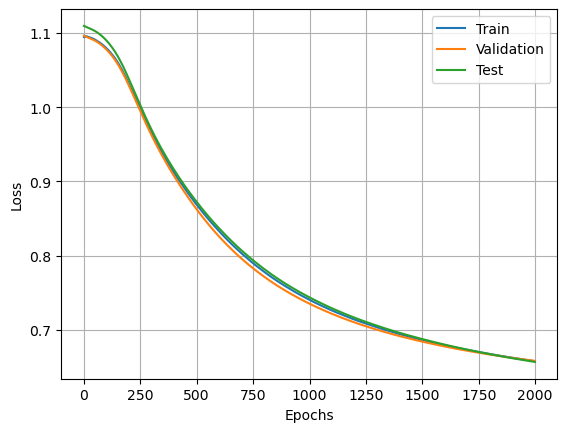

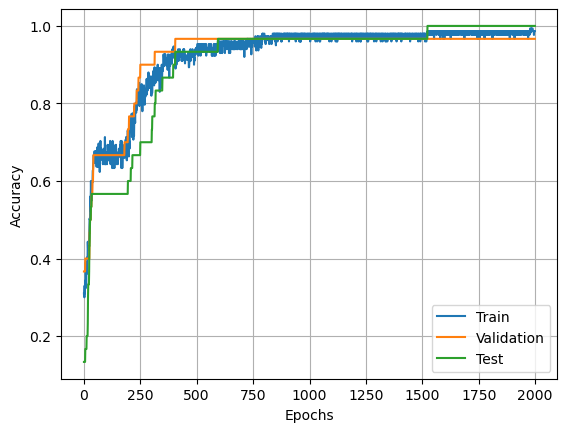

Train Loss:  0.6578533483147622
Validation Loss:  0.658235790103674
Test Loss 0.6568418625295163
Train Accuracy:  0.9866666666666667
Validation Accuracy:  0.9666666666666667
Test Accuracy 1.0


In [7]:
loss_fn = nn.CrossEntropyLoss()
lr = 1e-4
epochs = 2000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ann_model, train_loss, val_loss, test_loss, train_accuracy, val_accuracy, test_accuracy = train(ANN_Model(len(X[0]) , len(Y[0])).to(device), loss_fn, lr, epochs, train_loader, val_loader, test_loader)

# Make prediction

In [8]:
index = 50
scaler = StandardScaler()
scaler.fit(X_train)
x_index = X[index]
x_input = scaler.transform(np.array([x_index]))
x_input = torch.tensor(x_input, dtype = torch.float32)
x_input = x_input.to(device)
y_index = Y[index]
y_output = torch.tensor(y_index, dtype = torch.float32)
y_output = y_output.unsqueeze(0)
y_output = y_output.to(device)
ann_model.eval()
with torch.no_grad():
    prediction = ann_model(x_input)
    loss = loss_fn(prediction, y_output)
    prediction = torch.argmax(prediction, dim = 1)
    prediction = prediction.cpu().numpy()
    y_output = torch.argmax(y_output, dim = 1)
    y_output = y_output.cpu().numpy()
    accuracy = accuracy_score(y_output, prediction)
    
print("Features: ", x_index)
print("Features scale: ", x_input.tolist())
print("Target: ", OHE.categories_[0][int(y_output)])
print("Prediction: ", OHE.categories_[0][int(prediction)])
print("Accuracy: ", accuracy)
print("Loss: ", loss.item())

Features:  [7.  3.2 4.7 1.4]
Features scale:  [[1.4546788930892944, 0.3177013695240021, 0.5355654358863831, 0.2535259425640106]]
Target:  Iris-versicolor
Prediction:  Iris-versicolor
Accuracy:  1.0
Loss:  0.5528438091278076
